In [1]:
# Import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


# Please note these are for testing only!
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel

# Set the plot size for this note book for easy readability
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
def get_data(path):
    '''
    --------------------------
    Input: File path to data
    Output: Dataframe with assigment data
    -------------------------
    '''
    df = pd.read_csv(path)
    return(df)

In [3]:
def train_test_split(df, train_percent=0.666666):
    '''
    --------------------------
    Split data into train and test sets
    Input: Dataframe containing assignment data
    Output: Training dataframe and testing dataframe
    split according to specified percentage
    -------------------------
    '''
    # Shuffle dataset
    df = df.sample(frac=1).reset_index(drop=True)
    
    # Calculate no. of training examples based on train_percent
    # Here we use 2/3, 1/3 by default as required by the assignment
    n_train = round(train_percent*len(df))
    
    # Filter the dataframe to get training and testing rows
    df_train = df[:n_train]
    df_test = df[n_train:]
    
    return(df_train, df_test)

In [4]:
def get_grid_search_vals(start_g, stop_g, start_s, stop_s):
    '''
    --------------------------
    Input: 1) start_g: starting exponent for gamma
           2) stop_g: ending exponent for gamma
           3) start_s: starting exponent for sigma
           4) stop_s: ending exponent for sigma  
    Output: Two lists of gamma and sigma values
    that will be searched over for 'good' model
    parameters
    -------------------------
    '''
    gamma_powers = np.arange(start_g, stop_g + 1, 1)
    sigma_powers = np.arange(start_s, stop_s + 1, 0.5)
    
    gamma = np.power(0.5, gamma_powers)
    sigma = np.power(2, sigma_powers)
    
    return(gamma, sigma)

In [5]:
def get_pairwise_dist(A, B):
    '''
    --------------------------
    Load data from source
    Input: A: An array of x-values np.array
           B: Another array of x-values np.array
    Output: Pairwise Euclidean distances between A and B
    
    The output from this function is used 
    to calculate the Gaussian kernel. We used
    einsum here because we read that it can 
    provide a speed advantage in these 
    situations.
    
    References for einsum:
    https://ajcr.net/Basic-guide-to-einsum/
    -------------------------
    '''
    # 1) Element wise product and then sum horizontally
    # 1) Element wise product and then sum horizontally
    # 2) Dot product between A and B.T
    dist = np.einsum('ij,ij->i',A, A)[:,None] + np.einsum('ij,ij->i',B,B) - 2*np.dot(A,B.T)
    return(dist)

In [6]:
def get_gaussian_kernel(X, X_test, sigma):
    '''
    --------------------------
    Input: X: Training matrix
           X_test: Testing matrix
           sigma: Parameter for Kernel
    Output: Gaussian kernel matrix K(X, X_test)
    
    This function computes the 
    Gaussian kernel matrix for X and X_test.
    It calls the pairwise distance function above
    to first create the matrix of distances. Then 
    It scales and exponentiates them to recover 
    the kernel values.
    -------------------------
    '''
    scale = -0.5/np.power(sigma, 2)
    K = get_pairwise_dist(X, X_test) 
    K = K*scale
    K = np.exp(K)
    return(K)

In [7]:
def get_kernel_ridge_coeff(X, Y, sigma, gamma):
    '''
    --------------------------
    Input: X: Feature values from training data
           Y: Feature labels 
           sigma: parameter for Gaussian kernel
           gamma: regularization parameter
    Output: Analytical dual ridge regression coefficients
            [alpha]
    -------------------------
    '''
    # Store the no. of examples
    m = Y.shape[0]
    # Get the Kernel matrix for the training data
    K = get_gaussian_kernel(X, X, sigma)
    # Solve for the coefficients in the dual form using the analytical formula
    alpha = np.linalg.solve(K + gamma*np.identity(m), Y)
    # Reshape to add a column so alpha conforms to the test matrices later
    alpha = alpha.reshape(alpha.shape[0], 1)
    
    return(alpha)

In [8]:
def get_kernel_ridge_prediction(alpha, X, X_test, sigma):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    -------------------------
    '''
    # Get Gaussian kernel between K and K test
    K_test = get_gaussian_kernel(X, X_test, sigma)
    # Multiply element wise and then sum downwards to get # test points columns
    y_pred = np.einsum('ij,ij->j', alpha, K_test)
    return(y_pred)

In [9]:
def get_k_folds(df_train, k = 5):
    '''
    --------------------------
    Load data from source
    Input: df_train: Training dataframe
           k: no. of folds to divide this into
    Output: List of data frames where each
            dataframe is a fold
    -------------------------
    '''
    fold_size = round(len(df_train)/k)
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_folds = [df_train.iloc[i:i+fold_size] for i in range(0,len(df_train)-fold_size+1,fold_size)]
    return(df_folds)

In [10]:
def get_mse(Y, Y_hat):
    '''
    ------------------------
    Input: Y: Labels and 
           Y_hat: predicted values
    Output: Mean squared error
    ------------------------
    '''
    return np.sum(np.power(Y-Y_hat, 2))/max(Y.shape)

In [11]:
def plot_3d_mse(history, 
                k=5, 
                path = '1_3_cv_error.png',
                title = 'Cross Validation Error by Parameter Settings',
                log = False):
    '''
    --------------------------
    Input: history: dictionary containing
                    record of results from kernel
                    ridge training
            k: no. of folds [to use in plot labels]
            path: destination for generated plots
            title: plot annotation
            log: whether to plot on log scale or not
            
    Output: Plot of k-fold cross-validation MSE by
            parameter value after grid search
    -------------------------
    '''
    # Store the data
    x = np.array(history['gamma'])
    y = np.array(history['sigma'])
    z = np.array(history['mse_val'])
    ln_z = np.log(z)
    
    # Make the plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Make the plot
    if log: 
        ax.scatter3D(x, y, ln_z, c=ln_z, cmap='jet_r');
    else: 
        ax.scatter3D(x, y, z, c=z, cmap = 'jet_r')
    ax.set_title(title)
    
    # Set the z-axis label
    if log: 
        z_label = r'Log Mean MSE over {} folds'.format(k)
    else: 
        z_label = r'Mean MSE over {} folds'.format(k)
    
    # Set labels
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel(r'$\sigma$')
    ax.set_zlabel(z_label)
    
    # Save and then display
    path = os.path.join('.', '..', 'figs', path)
    plt.savefig(path)
    plt.show()

In [12]:
def train_kernel_ridge(X_train, X_val, Y_train, Y_val, sigma, gamma):
    '''
    --------------------------
    Input: X_train: Training features
           X_val: Validation features
           Y_train: Training labels
           Y_val: Validation labels
           sigma: Parameter for Gaussian
           gamma: Regularization parameter
    Output: Results from kernel ridge training
            alpha: coefficients
            Y_pred_train: predictions on training set
            y_pred_val: predictions on test set
            mse_train: MSE on training set
            mse_val: MSE on validation set
    -------------------------
    '''
    # Get dual form estimates
    alpha = get_kernel_ridge_coeff(X_train, Y_train, sigma, gamma)

    # Get predictions
    y_pred_train = get_kernel_ridge_prediction(alpha, X_train, X_train, sigma)
    y_pred_val = get_kernel_ridge_prediction(alpha, X_train, X_val, sigma)
    
    # Get loss values
    mse_train = get_mse(Y_train, y_pred_train)
    mse_val = get_mse(Y_val, y_pred_val)
    
    # Return statement
    return(alpha, y_pred_train, y_pred_val, mse_train, mse_val)

In [13]:
def get_best_params(history):
    '''
    --------------------------
    Input: history: dictionary containing
                    record of kernel ridge
                    grid search
    Output: 
    -------------------------
    '''
    best_run = np.array(history['mse_val']).argmin()
    best_val_mse = np.array(history['mse_val']).min()
    
    best_gamma, best_sigma = history['gamma'][best_run], history['sigma'][best_run]
    best_alpha = history['alpha'][best_run]
    
    best_params = {'best_run': best_run, 
                   'best_gamma': best_gamma, 
                   'best_sigma': best_sigma, 
                   'best_val_mse': best_val_mse, 
                   'best_run_alpha': best_alpha}
    
    return(best_params)

In [14]:
def test_pairwise_dist(A, B):
    '''
    --------------------------
    Load data from source
    Input: Path to data
    Output: Data-frame
    
    References for einsum:
    https://ajcr.net/Basic-guide-to-einsum/
    -------------------------
    '''
    dist = get_pairwise_dist(A, B)
    dist_sk = cdist(A, B)**2
    return(dist, dist_sk, np.allclose(dist, dist_sk))


def test_gaussian_kernel(X, X_test, sigma):

    kernel = get_gaussian_kernel(X, X_test, sigma)
    kernel_sk = rbf_kernel(X, X_test, 0.5)
    return(np.allclose(kernel, kernel_sk))

def test_kernel_ridge_coeff():

    a = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2,4)
    b = np.array([2, 4]).reshape(2,1)
    result = get_kernel_ridge_coeff(K, b, 1, 2)
    return(result)

def test_kernel_ridge_prediction():

    a = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2,4)
    b = np.array([5, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 21, 25, 26, 7, 8]).reshape(4,4)
    
    alpha = test_kernel_ridge_coeff()
    result = get_kernel_ridge_prediction(alpha, a, b, 1)
    
    return(result)


def tests():

    # Make test data
    a = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2,4)
    b = np.array([2, 4, 6, 8, 10, 12, 14, 16]).reshape(2,4)
    
    dist_test_result = test_pairwise_dist(a, b)
    kern_test_result = test_gaussian_kernel(a, b, 1)
    
    coeff_test_result = test_kernel_ridge_coeff()
    prediction_test_result = test_kernel_ridge_prediction()
    
    return(dist_test_result, kern_test_result)

In [15]:
def main(k=5, mode='single'):
    '''
    --------------------------
    Inputs: k: No. of folds
            mode: run for single run
                  or multiple runs
    
    This is the main training loop
    for kernel ridge regression. 
    We set parameters here and
    do a grid search over the 
    values specified in the question
    using k-fold cross-validation. 
    We return the best parameter
    values and the associated error 
    metrics. As a side effect
    we make CV error plots across
    the search space.
    -------------------------
    '''
    # Setup
    path = 'http://www0.cs.ucl.ac.uk/staff/M.Herbster/boston-filter/Boston-filtered.csv'
    
    # Set parameters for grid search
    start_g = 26
    stop_g = 40
    start_s = 7
    stop_s = 13
    
    # Get list of parameters to search over
    gamma_list, sigma_list = get_grid_search_vals(start_g, stop_g, start_s, stop_s)
    
    # Load data
    df = get_data(path)
    
    # Split into train and test: we are making 2/3 splits as required by default
    df_train, df_test = train_test_split(df)

    # Divide training data into k=5 folds for cross-validation as question asks
    df_folds = get_k_folds(df_train, k)
    
    # Convert data-frames into numpy arrays
    X_folds = [df_fold.iloc[:,:12].to_numpy() for df_fold in df_folds]
    Y_folds = [df_fold['MEDV'].to_numpy() for df_fold in df_folds]
    
    # Create a container to store results
    history = {'gamma': [],
               'sigma': [],
               'mse_val': [],
               'mse_train': [], 
               'pred_train': [],
               'pred_val': [],
               'alpha': []}
    
    counter = 0
    
    # This loop iterates over the grid
    for sigma in sigma_list:
        for gamma in gamma_list:
            
            # Record the parameter values
            history['sigma'].append(sigma)
            history['gamma'].append(gamma)
            
            # Print progress check
            counter += 1
            print(counter)
            
            # Make containers for train and validation MSE by fold
            mse_train_by_fold = []
            mse_val_by_fold = []
    
            # Now train for each fold
            for i in range(k):
        
                # Stack data matrices
                X_train_fold = np.vstack(X_folds[0:i] + X_folds[i+1:])
                Y_train_fold = np.hstack(Y_folds[0:i] + Y_folds[i+1:])
            
                # Get the ith fold and take it as the validation labels
                # The rest of the data are stacked and put in a container
                X_val_fold = X_folds[i]
                Y_val_fold = Y_folds[i]
        
                # Train the ridge regression
                alpha, y_pred_train, y_pred_val, mse_train, mse_val = train_kernel_ridge(X_train_fold, 
                                                                                         X_val_fold, Y_train_fold, 
                                                                                         Y_val_fold, sigma, gamma)
                
                # Store the result
                mse_train_by_fold.append(mse_train)
                mse_val_by_fold.append(mse_val)
                
            print(mse_train_by_fold)
            print(mse_val_by_fold)
            
            history['alpha'].append(alpha)
            history['pred_train'].append(y_pred_train)
            history['pred_val'].append(y_pred_val)
            history['mse_val'].append(np.mean(np.array(mse_val_by_fold)))
            history['mse_train'].append(np.mean(np.array(mse_train_by_fold)))
    
    # Store best parameters
    best_params = get_best_params(history)
    best_gamma = best_params['best_gamma']
    best_sigma = best_params['best_sigma']
    
    print("The best gamma value is: {}".format(best_gamma))
    print("The best sigma value is: {}".format(best_sigma))
    
    # Make plot
    if mode =='single':
        plot_3d_mse(history)
        plot_3d_mse(history, log=True, path='1_3_log_cv_error.png')
    
    # Now store full train and test sets for training with best parameters
    X_train = df_train.iloc[:,:12].to_numpy()
    Y_train = df_train['MEDV'].to_numpy()
    
    X_test = df_test.iloc[:,:12].to_numpy()
    Y_test = df_test['MEDV'].to_numpy()
    
    # Now retrain on the full data-set with best model
    alpha, y_pred_train, y_pred_val, best_param_mse_train, best_param_mse_test = train_kernel_ridge(X_train, X_test, Y_train, 
                                                                                 Y_test, best_sigma, best_gamma)
    
    
    return(history, best_params, best_param_mse_train, best_param_mse_test)

In [16]:
def execute_many(n_runs=20, mode = 'many'):
    
    history = {'gamma': [],
               'sigma': [],
               'mse_train': [],
               'mse_test': []}
    
    for n_run in range(n_runs):
        print("This is run {}".format(n_run))
        _, best_params, best_param_mse_train, best_param_mse_test = main(mode='many')
        history['gamma'].append(best_params['best_gamma'])
        history['sigma'].append(best_params['best_sigma'])
        history['mse_train'].append(best_param_mse_train)
        history['mse_test'].append(best_param_mse_test)
        
    avg_mse_train = np.mean(np.array(history['mse_train']))
    avg_mse_test = np.mean(np.array(history['mse_test']))
    std_mse_train = np.std(np.array(history['mse_train']))
    std_mse_test = np.std(np.array(history['mse_test']))
    
    return(avg_mse_train, avg_mse_test, std_mse_train, std_mse_test)

1
[1.1991008700406747, 2.0970554036469284, 1.5439065137871697, 1.7919774733435578, 1.1439219922142196]
[53.40280698398753, 75.9317807517602, 5702.762555862329, 276.2812225665872, 165.62084746937416]
2
[1.0324665314922834, 1.7782015940219167, 1.2668616658133578, 1.4814674048011596, 0.9107721998205953]
[60.256787074879085, 80.37666337149089, 9974.48315800749, 410.6629332565991, 216.13367476028634]
3
[0.868492726638042, 1.4630764232430349, 1.019497747633562, 1.198688985635621, 0.698719235764513]
[66.68765666724696, 83.16864067569593, 15566.514865827054, 575.3304635260439, 269.9716581734507]
4
[0.7093971089519611, 1.179700296856474, 0.8095695737362638, 0.9568506545573343, 0.5285492597277989]
[76.44503277521508, 89.49103453398389, 22228.954506468966, 782.2769546396578, 325.4523982421513]
5
[0.5588201073977986, 0.9343012005045156, 0.6307534678529153, 0.7577462445529456, 0.41223630423420765]
[97.38015184376495, 103.31019887226653, 30323.896927895592, 1128.9685317938722, 385.55421931996943]
6


[0.33195611714646284, 0.5638822304004499, 0.37685704059569275, 0.4853649141915814, 0.3063573836171027]
[377.20141013468486, 115.1647180987562, 7882.5000567899515, 2956.709979417401, 537.809102201304]
44
[0.2505523753654907, 0.4113010982158197, 0.27897189720272625, 0.3573146653710063, 0.276718735600641]
[423.92759705041044, 165.2041510017372, 1108.6381240663677, 6045.969779141589, 603.7271270403804]
45
[0.1948031565219413, 0.3030760405574975, 0.19980099398977721, 0.2589298083725442, 0.251908721959969]
[465.11077347114957, 266.1216678983921, 38278.11944213283, 11827.761949777141, 678.1971678655206]
46
[3.7123098417182616, 4.885821131905835, 4.2297277719524216, 4.8139941538660045, 3.8319706892161283]
[17.489601888952667, 10.007917700061922, 161.56975214629148, 27.013250933311628, 17.68677916786189]
47
[3.2079160725877514, 4.436376222877063, 3.729687652134701, 4.3262088452325544, 3.404666760313436]
[19.16415202096148, 9.938115813102854, 389.49621779904567, 35.80975243792436, 19.26312775557

[1.7081661456428663, 2.885851914322372, 2.227597690483194, 2.6671587585346463, 1.8083098597201837]
[29.15801267288358, 19.343666841650883, 19819.0660945061, 263.09137576682076, 64.6304384042078]
89
[1.5511022562732217, 2.6565433787025947, 2.0247800290720788, 2.4564550397667424, 1.5722271904393805]
[32.550784918861986, 23.08944060255509, 13645.03515554957, 328.22015355245605, 86.97166390436799]
90
[1.409196552501178, 2.394880255920684, 1.8229689906653461, 2.248951558070952, 1.3622931089685923]
[37.62390982266196, 28.51000154836898, 2126.477689289249, 396.17313756380724, 116.97045095287152]
91
[7.403991990822272, 8.458020108241177, 7.8707933370717695, 7.485148156800962, 7.023721884153415]
[13.528395132016897, 8.486152772304347, 103.1221970187707, 18.007355216040647, 16.3154154773525]
92
[6.9367327731746995, 8.012754366807444, 7.44853429006998, 7.171908973933002, 6.691940060886362]
[13.700699559472826, 8.580731920377277, 122.35944069480922, 18.59925396223162, 16.484386362424022]
93
[6.468

[10.500118096162906, 11.885897201312584, 11.513119593902163, 11.408956388173186, 10.33421383289928]
[20.49348857689377, 11.851457985506366, 35.267817737023194, 13.34609018687025, 16.432994654692]
138
[9.811859375724918, 11.055929123949886, 10.559810484147189, 10.303430652431517, 9.359072543885416]
[18.331418745051117, 10.941821726690575, 63.29766998650126, 13.691152581155793, 16.243470982864004]
139
[9.321288505489367, 10.500579162369991, 9.900242866683987, 9.508139848199212, 8.707015284478507]
[16.663332470725347, 10.267199701585945, 99.14510467863701, 14.908471808918032, 16.309951580676206]
140
[8.913827203495448, 10.076378888394554, 9.386066520107432, 8.90751556540238, 8.245069447663612]
[15.428551835354975, 9.665901776368013, 134.52418819921746, 16.595684860661184, 16.419970999222404]
141
[8.517599388584074, 9.685444620624304, 8.938381284679956, 8.416816317103175, 7.886196950961075]
[14.541261451496004, 9.066922658451684, 169.27594356252214, 18.088578096568256, 16.443946871140568]


[13.17431257655983, 14.95408775357044, 14.88112471784297, 15.023874879098937, 13.748342834338793]
[26.077315155233, 15.070736628447227, 28.180036989335587, 15.679892912066217, 18.469781265045363]
187
[11.655862952629105, 13.170653904839726, 13.073693577847303, 13.008463877352144, 11.786869411821534]
[22.883225820271953, 13.356578288863277, 20.45965481131471, 14.224555217305271, 17.26434672299938]
188
[10.617463036601938, 11.944037055126392, 11.720555056540935, 11.499027125748942, 10.37654310633159]
[20.241252785705573, 12.013978343841432, 14.151712110359707, 13.532075341003356, 16.63013893659192]
189
[9.943656928965561, 11.158343115783984, 10.804761155027053, 10.424414234238489, 9.440986712494405]
[18.177809610191677, 11.078006482574281, 14.036215906641099, 13.82352221890033, 16.45957934550746]
190
[9.486617717471308, 10.659271857500938, 10.179106859113299, 9.663880143379236, 8.834941103890705]
[16.663693537428532, 10.428651566460395, 26.30923140453981, 15.116712513258541, 16.542094729

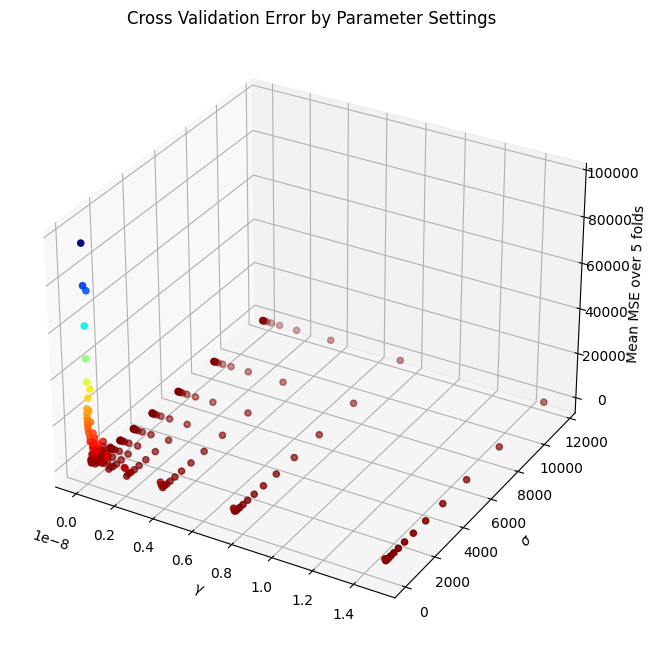

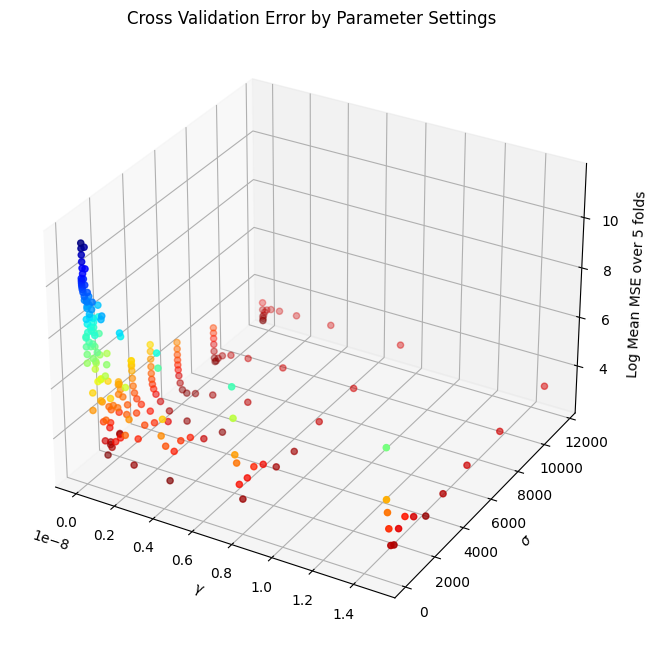

In [17]:
np.random.seed(4109)

history, best_params, best_param_mse_train, best_param_mse_test = main()

In [18]:
# Print results from one run
print(best_params)
print(best_param_mse_train) 
print(best_param_mse_test)

{'best_run': 205, 'best_gamma': 1.4551915228366852e-11, 'best_sigma': 11585.237502960395, 'best_val_mse': 14.526970806167643, 'best_run_alpha': array([[ 4.99916475e+10],
       [ 9.63131209e+10],
       [-2.86677253e+11],
       [ 4.16573666e+10],
       [ 6.38376990e+11],
       [ 5.46819960e+10],
       [-1.42668801e+11],
       [-3.04498754e+10],
       [ 3.99008436e+11],
       [ 1.17688753e+10],
       [-1.18141135e+11],
       [ 9.34342783e+11],
       [ 7.64347343e+10],
       [ 1.73739766e+11],
       [ 1.30648851e+11],
       [-1.08908289e+11],
       [-5.73940588e+10],
       [ 2.21023253e+11],
       [ 3.06835259e+11],
       [-1.84288195e+11],
       [ 2.55839073e+11],
       [ 3.42518699e+10],
       [-1.00962740e+11],
       [ 1.71319540e+11],
       [ 2.55162205e+11],
       [-1.43398784e+11],
       [-1.01303186e+11],
       [-5.31320004e+09],
       [-1.33794975e+11],
       [ 6.63179390e+10],
       [ 2.38297493e+11],
       [ 1.31572904e+11],
       [ 1.19071534e+11]

In [19]:
# Print results from many runs
avg_mse_train, avg_mse_test, std_mse_train, std_mse_test = execute_many(mode='many')

This is run 0
1
[0.7987614442788298, 1.068184612473041, 1.184186788552603, 1.178638321001634, 1.1465384251576887]
[75.29460065090282, 467.4548639835338, 565.5500607571328, 90.06887802590619, 81.48302951870573]
2
[0.6806522249605368, 0.8795714619429316, 0.9594808642043424, 0.9612796099005012, 0.9286069233954447]
[87.41094665381233, 747.0521537405227, 709.6668622222307, 108.09070544773544, 123.88537204289382]
3
[0.5681444414004541, 0.7081630086804456, 0.7770317743108069, 0.7509493743189849, 0.7495840927520321]
[85.42788296995295, 1014.1634521570355, 756.386945336942, 134.21013445163683, 166.98199255789925]
4
[0.4728805972536126, 0.5513750883105621, 0.6360727544216821, 0.565116502904751, 0.6072868610739985]
[78.8731365247133, 1187.1692162267025, 706.0729326690939, 176.157682601674, 197.78062824716736]
5
[0.4000725110250553, 0.41655397378306397, 0.5262101042779629, 0.42206124914641163, 0.49480742850241094]
[152.5383266922422, 1339.6899490107605, 608.2064541710081, 239.68173168381514, 215.7

[1.976520401884929, 3.0691393686012804, 2.885531252769833, 2.9942209238450963, 3.1908187004527337]
[26.608781378300336, 34.73164695362498, 28.158130127783704, 30.741077511805788, 7.277884073583124]
49
[1.7449029677664214, 2.6017231857026335, 2.5119837380854944, 2.62891984541707, 2.6937253153819056]
[32.45259712857695, 50.316021796929185, 34.75499649787724, 34.923152058300694, 8.825848425671046]
50
[1.5508677846442198, 2.210049699841655, 2.2065598401309723, 2.29050563233697, 2.2700953019282832]
[42.40437318958589, 73.02878277183953, 42.120245004402115, 40.35216581218286, 12.346974606579112]
51
[1.3898716644075746, 1.8972633291636645, 1.9543927724453058, 1.9932089360427176, 1.9417110344290789]
[57.56180534540353, 101.10990699032622, 48.24649703714484, 47.6533846512205, 18.52105618213127]
52
[1.2525942412295057, 1.6473225600316492, 1.7386259062289426, 1.7470043906960875, 1.6916334624602998]
[79.23094912649302, 135.35556120439162, 52.028418687272485, 56.86647078854568, 27.80427807336236]
5

[3.819642840881669, 5.579699786711012, 5.583084530908037, 5.16175951544304, 5.649279719958554]
[19.409595614165482, 15.953191163497289, 10.617918560949661, 17.985807881268933, 8.58333895028757]
97
[3.452939745759794, 5.110183857229333, 5.114420413903283, 4.712747861485105, 5.23154645829385]
[20.95408167944754, 18.206551515141904, 10.92459586287892, 19.860543072616693, 8.316778098146669]
98
[3.13056240429503, 4.611143224026032, 4.59718548624286, 4.2783527883857, 4.784064173081775]
[22.122475612739105, 20.789027825428736, 11.918030701084826, 21.871329954894644, 7.964484063550548]
99
[2.8152795324992486, 4.076810228503637, 4.029040530339741, 3.839351945970807, 4.2883482863693425]
[22.799751251184478, 22.307914845109334, 13.995304662052485, 23.7327142470806, 7.503187285630759]
100
[2.49647561348946, 3.5248540976454756, 3.4483663235618165, 3.3980799520164013, 3.7521695411233176]
[23.64426106083201, 21.849972478458962, 17.496570819885967, 25.05709451789516, 7.01109478261173]
101
[2.194773538

[6.553161966702059, 7.4770766226583705, 7.78095669207627, 7.411783480991477, 7.9775797087769345]
[14.453208872593535, 16.485715744440427, 10.377784496753712, 14.173483951555149, 8.892874922496102]
144
[6.119035722034058, 7.229510231723184, 7.457901311741314, 7.067862166739422, 7.624563777869178]
[14.77601424239588, 16.723040090001888, 10.378045281635949, 14.441817264639107, 8.794285999168363]
145
[5.621261752848621, 6.973156859530751, 7.1008282987832585, 6.680187450374201, 7.246941249603232]
[15.353924778287059, 16.320937446846116, 10.497191780129059, 15.007248963138904, 8.67463811035796]
146
[5.075913282571449, 6.667919270899547, 6.716569416149408, 6.255962181603918, 6.836269503127672]
[16.362048552140955, 15.46827169639868, 10.735957518048, 15.857268354174776, 8.532478916682303]
147
[4.5492045048522805, 6.295798109885507, 6.320213770693195, 5.822257145221637, 6.407960028821853]
[18.02888457208761, 14.706368817707189, 11.026591425170539, 16.9458975340932, 8.40649562628856]
148
[4.1116

[7.898599739068764, 8.601066602658655, 8.782919884110843, 8.439585988930462, 9.252956388857244]
[14.44912048217354, 13.314312838741836, 10.815549356312173, 14.173720612244598, 9.353751845119604]
192
[7.558506517389843, 8.241168531208688, 8.45923463403678, 8.129831924003673, 8.929323224248503]
[14.173940350412211, 14.546013061876561, 10.77660979407381, 14.200555697521052, 9.029189390829249]
193
[7.2541894880737825, 7.926737260773305, 8.183609726152648, 7.8602700023597745, 8.63494000186671]
[14.045766788945715, 15.710003680519538, 10.804179920151606, 14.247516957532556, 8.783240581110343]
194
[6.950652204035822, 7.646323094339068, 7.933020157542693, 7.587366702049525, 8.346477664993769]
[14.035711073377241, 16.594539115197627, 10.859334539450819, 14.294067346088921, 8.613630636521238]
195
[6.592666585725634, 7.380598533965314, 7.675704886228291, 7.286574937167452, 8.049516704865356]
[14.160770764626674, 17.0763888913393, 10.959053302985518, 14.539980397402351, 8.423135460953214]
196
[20.

[0.7618736848997516, 0.8410490062975526, 0.6928536780710687, 0.4084434744511935, 0.525415200116772]
[173.03419483481687, 3490.4805328969937, 133.6960185612473, 287.3246427018182, 131.99697633155856]
26
[0.6109681282755487, 0.6868355302448558, 0.5881275624570309, 0.29591442497249953, 0.4443381348683651]
[202.96134606571803, 4041.2490189973337, 164.99417173773415, 365.20733564368396, 156.96201068134118]
27
[0.4869414051801146, 0.557298819296551, 0.48537265472004343, 0.2118227880201019, 0.35680033106429104]
[240.61993987362797, 3862.1982328402146, 205.52325312991454, 478.4745834739177, 207.3169620807287]
28
[0.3898177799571325, 0.4501541857460307, 0.38789676224802, 0.15486668307307286, 0.26545673085595334]
[308.231405764227, 3468.4516461795547, 257.92851149409563, 633.7344556408376, 319.5395513552165]
29
[0.31547716749509297, 0.35668362739482207, 0.30129603851753306, 0.11919898673350435, 0.17870660417302242]
[456.4549270813492, 3674.835000919939, 317.3108102921176, 842.1278336177319, 530.

[3.457874624384534, 3.537700238345648, 3.221504212625604, 2.5147617625424776, 2.6383273239301954]
[22.098873692820504, 127.37805272578301, 13.863731657342893, 51.62674875910942, 44.656408742667914]
68
[3.0851796164092846, 3.133075724632661, 2.794026113720998, 2.3120428111717604, 2.3732877058593793]
[26.9801978062329, 179.74615002716078, 14.79094340542922, 57.86716054530407, 51.815862313504844]
69
[2.7683236844349777, 2.8040403971488885, 2.414983233611298, 2.1390426165677616, 2.1444991486325966]
[32.043662659371506, 197.89932576392354, 16.31394721316658, 63.388395993369215, 57.55836036286031]
70
[2.5011451104885873, 2.523485624485894, 2.0890314981165323, 1.978347354908036, 1.932317829989246]
[37.319709404384966, 174.84395906038532, 19.240613604182183, 67.98843563759067, 61.053940403011524]
71
[2.2808102008074314, 2.279637476550993, 1.8175283806386493, 1.8215295362965032, 1.728746578861367]
[42.413616833616516, 130.86455679435906, 24.244282113824504, 72.30768742571901, 63.66194055812893]

[7.547867814595497, 7.437583188894448, 7.0634287427466385, 5.517330397569019, 5.737328156345224]
[12.064501293537678, 12.021640171798987, 10.904263974612077, 26.371600174890172, 24.505015805522657]
113
[7.1653685254683035, 7.050976033626027, 6.6836370549326505, 5.2205451869098605, 5.410319148012208]
[12.607252281084023, 14.410653694332282, 11.204286243593032, 28.36839682257719, 26.199581303030264]
114
[6.734273892069774, 6.65768948008453, 6.262254143572324, 4.925174406105878, 5.0789358389834405]
[13.247486698947274, 17.549630842469394, 11.475827473849133, 29.90602397151065, 27.260350064393037]
115
[6.2438085497171505, 6.235130415175114, 5.774758519003485, 4.585345225200481, 4.712522858561517]
[13.916809019305969, 20.425741306214945, 11.652040999012712, 31.144384967798793, 27.703679583800966]
116
[5.693043710423415, 5.75028921167784, 5.219143020008074, 4.181984450743081, 4.313705533731206]
[14.454852058821011, 22.404269006531003, 11.752514734765525, 32.49796094863032, 27.90310489995209]

[9.024071481421231, 9.031330807069189, 8.762304879026491, 7.427374009131261, 7.493816139006038]
[12.27553398791271, 10.743945953949579, 10.38512252150855, 18.003045234511315, 18.89978983937678]
161
[8.686349094953792, 8.751492825751809, 8.462585054086748, 7.065079058013773, 7.2064059786921115]
[12.82199927788677, 10.964231276945037, 10.301803399924424, 19.1533044794735, 19.674829950910546]
162
[8.366739946064712, 8.467949290351712, 8.150202373691084, 6.7174470763434675, 6.914733189989243]
[13.33628560075924, 11.469405800873247, 10.401190953043557, 20.56083689174799, 20.554692296043257]
163
[8.042378512161067, 8.151235707813123, 7.798383565938183, 6.3612931677705955, 6.594757413214157]
[13.779247810184788, 12.447456064485012, 10.627568166074694, 22.182172448639342, 21.534567646653347]
164
[7.6983347394002895, 7.7813076341969545, 7.408851181781336, 5.988318340216883, 6.23358310135554]
[14.13016453313266, 14.264363320045065, 10.90485693136258, 23.927242745720964, 22.622553510968366]
165
[

[13.38323257949429, 13.119127515750845, 12.816467840911596, 11.739821041261653, 11.62269552136063]
[12.020163970676055, 13.648033469350942, 13.038539823147053, 19.818831123228424, 20.022348070456545]
205
[12.223114291288521, 11.976903072711973, 11.63950230138774, 10.74501494424303, 10.487674807967483]
[11.103011056601057, 12.807199583614945, 12.376229100930894, 18.018004473082502, 18.99474971537642]
206
[11.427820015790944, 11.259167098007788, 10.868230728806767, 10.061711664446038, 9.738260732141198]
[10.765075840444146, 12.276441314300884, 12.104849350041757, 16.808474764115836, 18.447527955730603]
207
[10.862503483798276, 10.778131055934127, 10.361540978909648, 9.550250754790143, 9.206572124948272]
[10.92933922027356, 11.866346988208734, 11.985313951465345, 16.175233959738698, 18.20683911489733]
208
[10.42791755867566, 10.39580623673667, 9.988929503395404, 9.11502641239982, 8.778989794530894]
[11.386806955299404, 11.50489087710451, 11.832126684279794, 15.998601890620014, 18.19117737

[0.7244613391605866, 0.84932492826428, 0.68954049272368, 0.8167787936938278, 0.9634264432507398]
[129.23239339380785, 249.91489966171108, 2798.7242216207783, 640.3067780918692, 972.474258926188]
41
[0.5971320010005293, 0.7602581636607774, 0.626016563008409, 0.6847283335494551, 0.8255218508468808]
[164.5876668300042, 402.7597549876929, 5294.990852610481, 907.8887144941361, 1043.6664578157458]
42
[0.4922912050257429, 0.6849609871027358, 0.5702418339513157, 0.578135915348442, 0.7252160590931436]
[209.9419664694633, 681.0584984659108, 9048.88124319944, 1173.2392129544755, 1190.0675408117759]
43
[0.40714172362502676, 0.6108895438149663, 0.5205886248828587, 0.49492963435780724, 0.6540626535927258]
[259.6568979437202, 1045.0318054915467, 13184.456056200344, 1451.989149334551, 1611.321083602193]
44
[0.33489386321510156, 0.5327300971440659, 0.47208394392919417, 0.4262876718448551, 0.5978909321314345]
[310.7461912942137, 1492.3588114324539, 15969.858127995689, 1831.9006726872913, 2554.5066156025

[2.0067391933942726, 2.018188982390783, 1.3536124209805267, 1.8915534435004326, 2.1891514384857755]
[26.19665715191543, 65.5361053339203, 167.25614848701144, 101.12775700132126, 102.66811133818396]
89
[1.727277611561342, 1.7625493323996162, 1.2177418397476814, 1.6469282493159565, 1.9702455177030234]
[39.710561812399234, 63.840015428689554, 255.98842145307012, 125.97855309100669, 107.37249499415505]
90
[1.4693197335614199, 1.5437321553190253, 1.101622221184644, 1.4537926556796892, 1.7668781643861264]
[61.617557112748045, 60.83040016506592, 370.61740000354047, 166.93680209837447, 221.7819520564399]
91
[8.537992686308066, 7.953657174322291, 7.241459075046271, 7.977342375236792, 8.53864303195504]
[10.68864367058627, 14.065983545136053, 18.27309310295171, 23.81736899579445, 13.684648432470434]
92
[8.14377895056138, 7.538132129695635, 6.850973984252237, 7.593303582767016, 8.181673122397278]
[10.9199543087366, 13.92957844227002, 17.730903933467136, 25.009732897352524, 13.629099692351629]
93
[

[13.62604548724716, 12.38272951670845, 11.717768656200743, 13.12643100409835, 13.119126320089503]
[13.20957288280195, 19.19534599832978, 20.169852711237077, 16.23743061851941, 15.87636088071461]
137
[12.335588337573098, 11.185504841884947, 10.29464435092001, 11.72978094644682, 11.783185371168413]
[11.551788307494725, 17.455515353442326, 20.117807175469377, 14.54549172497936, 14.785935616027434]
138
[11.402772499688632, 10.37287405521968, 9.361805008228982, 10.650202924243372, 10.865806077159192]
[10.563595264648002, 16.22724827445067, 20.262304664891474, 14.35391491324737, 14.299518437025007]
139
[10.70175381323066, 9.802090664681627, 8.755217635071402, 9.824265696880975, 10.214584206623684]
[10.108754486600407, 15.381533795188787, 20.26901490326652, 16.03974285934585, 14.346203558495587]
140
[10.146056402530348, 9.376039191937577, 8.342744937990442, 9.21517488941968, 9.723287117078042]
[10.020842413318979, 14.778901809771376, 20.073947247078493, 19.454634802429595, 14.813523740124461]

[20.650613714070712, 19.2036153900065, 19.757272595408413, 19.816492467119133, 20.36288949612984]
[21.211285085706788, 27.786137347369905, 24.368053922134333, 25.409480038683547, 23.366721797550504]
184
[19.202350100565873, 17.770184793905777, 18.09076982373973, 18.465276657512664, 18.880791677098102]
[19.595458835064672, 26.179239069142756, 23.079111445653194, 23.67207690213505, 21.67724097094497]
185
[17.385433996717065, 16.007502900959906, 16.009300324099794, 16.786289058581282, 17.009694230750327]
[17.490766321709145, 24.03803873610763, 21.727690563104687, 21.3730105233992, 19.72917049301532]
186
[15.42628609315067, 14.12513320903748, 13.77576716422341, 14.938216999393727, 14.981821462467101]
[15.17319776491221, 21.588225974214605, 20.56588408180646, 18.703391843833987, 17.727272380243168]
187
[13.706450759148279, 12.486885614333934, 11.824376074279547, 13.227173972246145, 13.190882772774035]
[13.102349794278394, 19.289481537149587, 19.93771489652017, 16.191364206940992, 16.0375545

[1.238686410294003, 1.2952005158950655, 1.5954789014876574, 1.3374280919966393, 1.3499474687269173]
[90.09026656540802, 30.117782316379362, 39.05059804482312, 98.9756362187717, 63.716894267423385]
19
[1.0784874712943413, 1.170028522556842, 1.459177167248257, 1.1551102733706857, 1.188398621518201]
[117.28381143945772, 49.68891450459611, 48.52864915041092, 111.05915337994539, 139.08680402328284]
20
[0.9346084003805607, 1.0666526109069783, 1.3261363636012609, 0.987113976442494, 1.0427376536130037]
[149.23228705667037, 103.26776548590664, 63.475678491084345, 121.32849467320011, 261.3895659559642]
21
[0.8077710046687381, 0.9697474286494588, 1.1887822485804944, 0.8439809929771752, 0.9162692021636705]
[185.87498784895413, 221.61482781237132, 86.86697708760212, 127.15069326180202, 418.21155250471105]
22
[0.6957012974247674, 0.8685318806705616, 1.0489579989518933, 0.7236586741962723, 0.8066790855011068]
[226.86629139090965, 432.83028403505676, 120.25718667771216, 124.0488126319209, 578.91781785

[2.355378894042624, 2.4525196599260126, 2.776394926449899, 2.4094661325429514, 2.496196687119656]
[16.609221430769097, 13.34734139809188, 23.087884787680633, 31.2750090931365, 12.692881336635716]
67
[2.1488908773525233, 2.1832460535383444, 2.5533898245985887, 2.2234491679336887, 2.281602470766573]
[18.613113992835952, 15.169810702706528, 26.81885324839385, 41.99774009388996, 14.881201498103174]
68
[1.9562281862735613, 1.9721312992874533, 2.3532934990527536, 2.0644965995158597, 2.1006437807220606]
[21.56079533243262, 17.173909566704946, 30.78147292795075, 54.0631509186213, 16.978347177326576]
69
[1.7767659414061303, 1.80486881105446, 2.174626914321881, 1.92291673751383, 1.9337135400211212]
[26.048792231576652, 19.60530927446382, 32.598604060948084, 63.19238482700694, 17.324007700627757]
70
[1.6122731116197513, 1.6633458997297985, 2.0107560496099484, 1.785718584222593, 1.7646142813459829]
[32.873122060539025, 22.38778790803211, 31.175618544644884, 64.90976720679112, 17.87212750115107]
71

[6.327710508156867, 6.5171261279071695, 6.254692192905354, 6.109041506869375, 6.476785054174353]
[10.523916121623046, 9.478335369780996, 11.516889885655944, 13.178052312007763, 9.079200992680454]
109
[6.021170445939002, 6.1930784068816545, 5.903426175936851, 5.866914373646084, 6.159090182226157]
[10.376083743661221, 9.437375307598229, 11.678204224760304, 12.732687853581274, 9.394518990410207]
110
[5.6733427887016985, 5.849485643896852, 5.5399223036297744, 5.584282554176914, 5.8313112550753665]
[10.391647471157809, 9.389101664615469, 11.910523185726664, 11.881837975088747, 9.643638443014694]
111
[5.286286899903381, 5.486138973407974, 5.17391604600343, 5.242399639741892, 5.4888632473223185]
[10.551691062643734, 9.294302512020563, 12.090660271364237, 10.979931647954947, 9.699827433806062]
112
[4.887573969860495, 5.113974705408764, 4.826993372078181, 4.8551143993746475, 5.139242012787146]
[10.880804246931389, 9.208700940539037, 12.166714788440798, 10.698373112197723, 9.484912190897623]
113

[7.216251165539164, 7.596816418300652, 7.383384667698916, 7.080346245773551, 7.730376756774654]
[12.318332235830663, 10.276852551809892, 12.40695733504661, 13.499874279140178, 9.067466667010871]
158
[6.973983265531155, 7.275472805166161, 7.0676945708365215, 6.770858732167359, 7.386895846084929]
[11.952635609385254, 10.164923491244975, 12.468887439839358, 14.092308609335763, 9.131221642390077]
159
[6.735967900447144, 6.957950325858918, 6.772356773173729, 6.507019155785598, 7.059780477185306]
[11.601569399923092, 10.089815687359678, 12.513767754969686, 14.427144987405208, 9.23758586445549]
160
[6.478145793751521, 6.641409577649869, 6.474861554308462, 6.265807039173027, 6.75363247649952]
[11.318912048101073, 10.05477388487305, 12.475487135195369, 14.469049387111854, 9.385392197620547]
161
[6.182200727878797, 6.326677041325862, 6.149281896098496, 6.025983236115157, 6.467374117685765]
[11.153831250293447, 10.05952210589208, 12.368883725583775, 14.235799345134884, 9.526634425165748]
162
[5.8

[8.533352549144558, 9.077772894966076, 8.850306023350932, 8.752202726319958, 9.308197471799941]
[13.607773765223692, 11.086990469750814, 13.222227923203357, 12.988193097613756, 9.254194367704043]
206
[8.002610870566, 8.50910928340753, 8.265855725866519, 8.0771211270885, 8.68214620050492]
[13.083110349584754, 10.646283154073476, 12.892743519701257, 12.801119173292598, 9.120316874157472]
207
[7.6451314474252285, 8.097050829052712, 7.863830222631876, 7.613109513971045, 8.264877081907793]
[12.756650514033584, 10.479585039949935, 12.829359091707127, 13.316047199173005, 9.236393759335847]
208
[7.367005302118826, 7.766834517569289, 7.5486361973944, 7.2762368159574695, 7.95071355008885]
[12.512655903537576, 10.483444881743626, 12.869539662873123, 14.009422023362106, 9.369178571236638]
209
[7.1446037699093115, 7.481086661162466, 7.271271528210213, 7.021592324699983, 7.671703526189885]
[12.29738866645009, 10.513157944523018, 12.946070918885631, 14.55507692491219, 9.496443176015987]
210
[6.926252

[0.8584873437589583, 0.9842321942951754, 0.8385447009728146, 0.8898315101162559, 0.6715551597308927]
[194.32804448453123, 217.94195211906086, 158.5452003659819, 269.2036252475011, 469.29302413276275]
41
[0.7386467395873404, 0.8681723310691096, 0.7285647666550491, 0.7913607602660299, 0.5464461175805819]
[286.5957268626981, 299.74002187480454, 213.06296943031563, 263.7612406893732, 704.4927903930577]
42
[0.6131651752256003, 0.7513463013004603, 0.6184304027926374, 0.7025383380602801, 0.4425366446509416]
[449.4388570844119, 480.07549881249173, 308.3342353908696, 271.54367642146605, 1004.3768469635884]
43
[0.4949505479620552, 0.6377957457680681, 0.5128313877015944, 0.6142963588193012, 0.3584737444339562]
[679.9957804170917, 828.6480373424537, 469.9783512709615, 492.6351012265017, 1329.067179853228]
44
[0.3978830097484682, 0.5359910398651665, 0.41890892002746427, 0.5210851964533859, 0.29323287596652425]
[911.4344787423612, 1457.555822817323, 728.6760526851156, 1290.7982412682638, 1643.621928

[1.7469129927444265, 2.1061382619557256, 1.9124149528281646, 2.036350415472842, 1.9319433758171527]
[28.752133640600103, 120.5877507705429, 31.869340325618648, 48.31778022256951, 51.18442254282548]
89
[1.6123711103423517, 1.9024114158818823, 1.7294261800139117, 1.8700729947890318, 1.741142390998247]
[34.24574800028052, 128.12022490405684, 38.75988527627055, 55.85166541140117, 64.88499810322843]
90
[1.4856582429343765, 1.7228521392535447, 1.5510863300944668, 1.7098334382831746, 1.5476493984666555]
[42.540186691379056, 134.5834687387765, 48.05505464137104, 58.76690475006811, 85.53874934017658]
91
[6.044459521755992, 6.792210387118504, 5.612595525406954, 7.234614412176758, 7.322301411991651]
[15.840651957629692, 10.597206400669704, 16.554291204126596, 9.156468831430898, 8.409423057814147]
92
[5.72908876539233, 6.4561990792481945, 5.302998463390899, 6.872771218427853, 7.029011709518153]
[15.970961148557423, 10.44443532782822, 16.81169652428932, 9.432605885524117, 8.355969399811409]
93
[5.4

[9.45333716379303, 10.48849677567392, 9.500574614449604, 10.994018002147552, 11.516918186250383]
[19.766124677187953, 13.46089297924154, 17.839648595100613, 11.717337812705331, 7.574428497282982]
137
[8.624271811216149, 9.52806166654915, 8.538322897950465, 10.02857247077664, 10.43981480226444]
[17.80391119591584, 12.704350653007566, 16.925710161667716, 10.78140749229361, 7.52427512090398]
138
[8.012605708628953, 8.837694873470259, 7.813225526578769, 9.338897049340991, 9.683726761015455]
[16.51025485852236, 12.218153022162971, 16.4238818781296, 10.326452239676808, 7.6107095841292605]
139
[7.536347728174602, 8.317234895900658, 7.2441405782919235, 8.845929373010385, 9.133741197036239]
[15.97562155574209, 11.932108287115117, 16.311750541607907, 10.144756542445425, 7.6947740749016305]
140
[7.141473676669646, 7.909565222986236, 6.795702321865352, 8.475868365667148, 8.698878763720142]
[16.101346696160896, 11.772348778143954, 16.472840805015604, 9.997802103215452, 7.747930612521072]
141
[6.791

[13.303558461708626, 15.190752094341361, 14.142280359901648, 15.149664763028921, 16.6446619032852]
[26.705377074336727, 17.47167513522495, 21.840600877240934, 17.956165302602457, 9.714502310814455]
185
[12.002441212640722, 13.605550175278438, 12.520102006770879, 13.779042227409349, 14.892858543901138]
[24.531594202691647, 16.07609267269964, 20.531190972613597, 15.993308540829835, 8.769003781121192]
186
[10.656309425367125, 11.972161369695067, 10.890565847665462, 12.311751044940062, 13.072266568646883]
[22.046648750474727, 14.55969756415321, 19.075347154036905, 13.897034734844858, 8.033756752116705]
187
[9.520903072313063, 10.616060288997563, 9.564516704767879, 11.036427817557893, 11.562365771567173]
[19.68239286164707, 13.329559563610792, 17.8257642287222, 12.186042878788413, 7.724776335221012]
188
[8.681827783742227, 9.634244713800022, 8.60292102508137, 10.07976241114285, 10.490511756584365]
[17.805742845676725, 12.526137777293272, 16.948329879998326, 11.111592214598577, 7.71855085045

[2.290315375224775, 1.8994147046655767, 2.196313891356345, 1.4790147569242478, 1.6048772842539403]
[47.725415299075344, 67.7138263401959, 26.64415451016901, 49.50304287255802, 43.96819195554769]
17
[1.9798794209576336, 1.6348498882511735, 1.8410236085814584, 1.3261961934171698, 1.34503443832904]
[59.64769669118138, 95.19575305504628, 32.43896571370263, 79.38510435378203, 57.06989742210656]
18
[1.7313559311176139, 1.378703417566354, 1.5188644824998383, 1.1875502942045408, 1.1519046297751858]
[76.99688616538594, 146.80844456303407, 44.113346641895625, 133.37779207187114, 78.79214210326371]
19
[1.5331217763055751, 1.1449851505616935, 1.2574626100412152, 1.0590714071494236, 1.0088935933224745]
[102.35334312215925, 242.66393060703695, 65.13997155982602, 225.74562771218942, 115.44644818679367]
20
[1.3715481619900625, 0.9626144105626665, 1.0657562738510382, 0.9395626775476292, 0.9025061710126223]
[135.29716765390032, 411.10822951870006, 100.36944397203463, 368.37666288421457, 172.095385528194

[4.545104426211634, 3.9608133051409538, 4.215238483231402, 2.7767796770395625, 3.767320174366107]
[10.156925022588995, 20.4161209424049, 15.954341198601153, 20.272530972008845, 23.8777421153534]
65
[4.100623812175091, 3.506427731694889, 3.776917772707466, 2.4109009839816435, 3.3089297921793532]
[13.73220236289668, 22.34584437251625, 18.54910932916888, 20.748098936223972, 25.871258262200655]
66
[3.6637427985254996, 3.0783201186004443, 3.373728167331115, 2.0884265237029576, 2.857227071037572]
[20.607068879578613, 25.744384478937985, 21.76490833609215, 20.849747518060795, 28.532440540872347]
67
[3.2496263536656187, 2.6948087096566797, 3.0084939224879577, 1.8319790934844156, 2.450247195381049]
[31.492874831005977, 33.76784365745045, 24.738154497332904, 21.49151306126733, 31.75112110742853]
68
[2.871651059178538, 2.3557608176347897, 2.671086156154465, 1.641594626112748, 2.1076058813751457]
[45.92127370938314, 55.768430198346714, 25.556841573992216, 23.485413698177506, 35.34843537554035]
69


[6.5446937025068035, 6.268046506177262, 6.50205113372516, 4.559583721642856, 5.413802815534881]
[7.752166000921573, 9.199949782634228, 9.99957225274381, 17.158993203723636, 19.338082894695805]
113
[6.2119416393667946, 5.8065598410370916, 6.115195436616978, 4.195755294271197, 5.14524430635498]
[7.248104607659836, 10.271609790661014, 9.82920129064801, 17.346245070565608, 19.925839947620034]
114
[5.864717596725956, 5.382733282449095, 5.73023575139292, 3.8619914185939668, 4.895176437156852]
[6.8911441587674105, 11.577070811250012, 10.25029223576368, 17.864424886842322, 20.362791254804485]
115
[5.497946323122324, 4.99114085910688, 5.340217227142499, 3.5388338842046263, 4.633321111174231]
[6.7048903703710945, 13.000130371165525, 11.055712287016457, 18.707438070020817, 20.688122993311147]
116
[5.1106519020901064, 4.606549164400734, 4.93678943345921, 3.211759597730559, 4.33329275869469]
[6.678472504696821, 14.467933139827652, 12.167682075419032, 19.841442582796873, 21.127865593153427]
117
[4.7

[10.631263804997104, 10.728944092634135, 10.780091571404048, 7.959818472602831, 9.0399210942263]
[8.69735909430922, 8.588358418680603, 9.211205257096827, 21.42150289023514, 19.15097931887889]
155
[9.826097879155368, 9.999715414455373, 10.086704236149977, 7.3486741694741955, 8.465504975760641]
[8.4167345085685, 8.305647279155936, 8.387674155107568, 20.748226094356102, 17.812905387784568]
156
[9.224594014468973, 9.482852771624678, 9.546430312862867, 6.94017419064956, 8.05660790382703]
[8.468057295339948, 8.211456233727306, 8.29003898900905, 20.233175816768636, 16.946760874486205]
157
[8.765768992862228, 9.089190450127877, 9.099394602404276, 6.6466787175860365, 7.751377475805524]
[8.724317181057124, 8.243901030775719, 9.099806357929118, 19.800267457432472, 16.417353110453053]
158
[8.4013217914461, 8.74817571875514, 8.712837031229624, 6.410521273936358, 7.4885228173499785]
[9.034173187400732, 8.337489120079487, 10.54949612094105, 19.40448607796759, 16.092881374153276]
159
[8.08633788337607

[20.470211060418592, 20.692659209394836, 20.640827194330846, 16.444958571607792, 16.80340308927386]
[15.761703790353105, 14.71834231234459, 14.586535396017611, 32.90540939201747, 32.91201599011014]
197
[20.0629551935107, 20.207088178505344, 20.177409934374968, 16.169525714328227, 16.456768830691622]
[15.570747340774307, 14.785811780245881, 14.464197293449969, 32.61358046680728, 32.295477371181576]
198
[19.532542734586766, 19.611629891691038, 19.59787834571934, 15.78873838119041, 16.016638158607723]
[15.289759381311443, 14.809704283912476, 14.32124275568994, 31.96416080424292, 31.60152456538418]
199
[18.853197384734976, 18.895277210253024, 18.88483155319411, 15.258583321668613, 15.481577205489087]
[14.905589835107563, 14.72331749062861, 14.126913707011655, 31.040134277014772, 30.764399969275942]
200
[17.939163145519625, 17.966762967000577, 17.94275503971259, 14.49630324888066, 14.792631014675498]
[14.332559974236396, 14.37317848961591, 13.808170353972264, 29.845531292270568, 29.63102227

[2.175958337916904, 2.483132315697179, 1.715273645820739, 1.9941889581693606, 2.247026411011299]
[91.96177035224463, 23.607617265538472, 24.155915223541925, 29.53825049051871, 16.49913598567234]
34
[1.8994896336420566, 2.196261362747215, 1.5679135517585816, 1.7763612428987046, 1.9995812581792392]
[124.63989346792977, 29.739988391442537, 39.963178504431156, 31.929429991392002, 22.5218615654595]
35
[1.6509513581138264, 1.9286861817326313, 1.433739855166831, 1.5801735721352042, 1.778651870414534]
[174.31118251842665, 44.857423707708726, 72.59248454112364, 35.228657250563586, 30.503482051529023]
36
[1.4367890503864693, 1.6896222838277748, 1.307181175125542, 1.403940063938148, 1.5712295995550853]
[245.21021690287773, 79.5038600974483, 127.22923231331711, 44.06352387765332, 40.705914243759615]
37
[1.2637707155079199, 1.4770145021987056, 1.1816646681824814, 1.240226520657282, 1.3791168989060432]
[318.4700250913659, 136.217734091779, 219.84878408675297, 65.94989572167096, 54.662130572245864]
3

[4.325024259486461, 4.324996978687884, 3.1640368630478664, 3.8451463383350153, 4.3687545914789325]
[9.155928311398837, 12.479918389836845, 17.98631271820159, 16.676539348572664, 6.676698166509433]
81
[3.9841671829471337, 3.966504597559443, 2.9200294383930614, 3.472883981418733, 3.966358707665205]
[9.62017371381212, 11.78894694832528, 17.34012651818125, 18.170492969740454, 6.716371149165282]
82
[3.6339432824631683, 3.62724375654008, 2.6782318447047855, 3.119094951249837, 3.5886576841130977]
[10.084868211203963, 10.61694529053111, 16.788652370236207, 19.735830398907613, 7.107672790065398]
83
[3.277075131869338, 3.3127556779411, 2.434286162004567, 2.799541567574103, 3.233460102329382]
[10.912910786267837, 9.536449632017352, 16.608851038273617, 21.144079984891793, 8.90126605038408]
84
[2.9206243186553986, 3.0151087761844386, 2.1962497574371374, 2.517614586620699, 2.901175240786903]
[12.845821827007004, 9.266449738168008, 17.175991858609844, 22.07221577352671, 13.47127655465955]
85
[2.57095

[5.754650488299935, 5.581428044089255, 4.264273949706695, 5.306969750460433, 5.938381732186646]
[7.882242376832882, 15.503402068070619, 18.309161218598646, 11.425096498740658, 6.598446228753427]
130
[5.413413894878207, 5.279691443823993, 3.9718023951118466, 4.908139073008587, 5.547490541731167]
[8.23225706889322, 14.693367113809087, 18.56053786738887, 12.243402143176368, 6.608207167685055]
131
[5.09812324482614, 4.975603869710007, 3.7108081219446802, 4.528577954928293, 5.170402036595999]
[8.81414634617351, 13.794705939117208, 18.829799961727947, 13.542529639240854, 6.654064232128699]
132
[4.784206919131884, 4.66400020893552, 3.467203225367772, 4.1748503306402425, 4.794530598840709]
[9.686585592500755, 13.016611473664863, 18.981158124984645, 15.222944853841815, 6.728172414703816]
133
[4.450717608379338, 4.3256235442899955, 3.232692849936325, 3.8306930154473036, 4.400481148376637]
[10.59090275132834, 12.223391572299287, 18.89584817790273, 17.02031670035711, 6.805538405249861]
134
[4.0897

[8.58743623556276, 8.222563590277447, 6.683840391174029, 8.00588249067052, 8.719113951962509]
[9.356714087988966, 10.17162289957064, 18.21229197080276, 11.161670335414966, 7.029228290335683]
174
[8.213286432007095, 7.796063865949217, 6.205664652496065, 7.614324889623362, 8.303665232019153]
[8.97741124336573, 10.561554427690934, 18.103945442165294, 10.869726370652797, 7.078356037165757]
175
[7.899505522264334, 7.444926843480206, 5.871089203774046, 7.285650325315246, 7.993147797579741]
[8.698123334499018, 11.114006943838225, 18.298687452489734, 10.720757621259692, 7.055666403964975]
176
[7.604535015819372, 7.118030673742655, 5.626051813104093, 6.987651794099512, 7.718755777831053]
[8.473968959444049, 11.786254281666853, 18.512662566017863, 10.737690728967314, 6.947027960473868]
177
[7.317030187903612, 6.803585961031269, 5.4189160745757725, 6.727354751610155, 7.442619041961359]
[8.283342457351399, 12.665735895700418, 18.677526275864736, 10.87465172169591, 6.8278521083434365]
178
[7.037785

[0.23556500581121564, 0.37286606601242944, 0.26067059882013843, 0.43720544349365625, 0.2992401411179494]
[929.4341963973367, 385.4722565317059, 38105.04865690906, 454.32751607297155, 4763.33847276785]
10
[0.19570100058011344, 0.3076948992818183, 0.20137714734797693, 0.3916573002000337, 0.270900470689374]
[891.4101640374148, 431.2755849470812, 61981.21272499512, 498.77235696504795, 5512.929679615401]
11
[0.16433372793938653, 0.244521782406802, 0.15266696199279184, 0.3434358733295412, 0.24100194255783308]
[750.4534261953112, 529.5278237869531, 65945.31677034637, 527.7365381829311, 5954.664125418793]
12
[0.13757346737796297, 0.180446027380538, 0.11264850298157769, 0.2929403627445328, 0.20600779873677977]
[652.8519620721754, 642.0251895190962, 41901.17956346263, 553.1664640145431, 6221.2619215284]
13
[0.11183730091524893, 0.11871360697931799, 0.07855503622109349, 0.23934059900764387, 0.1671799639845378]
[1170.951507465104, 722.4898077688814, 11365.192109837757, 589.3796434347433, 6510.6957

[0.8480385494659817, 1.1200316253292077, 1.154260749181444, 1.0344858253801412, 0.9012337395173424]
[155.8629252141422, 151.9150426136071, 75.09422422143842, 158.4175502911121, 399.31662738611936]
57
[0.7094001495022423, 0.9955931878090186, 1.043079803969088, 0.8898800549733724, 0.7620063518524629]
[254.8110808740517, 217.03506893175856, 93.73412966672966, 218.42029001917132, 601.0137013442335]
58
[0.5972864221648835, 0.8840252391667314, 0.9319424593106533, 0.7809549598422976, 0.6461934083921196]
[396.5962934228045, 289.8934248404639, 159.86976477870707, 289.16764248145296, 911.018667348978]
59
[0.5127033393023834, 0.7793443600937794, 0.8193919622895478, 0.6968233294516073, 0.54859313834681]
[573.9167759240305, 341.3886527150464, 287.6378994926885, 350.54133085327885, 1262.9402732010708]
60
[0.4469104278296707, 0.6784167404415847, 0.7059270763656148, 0.6267410994859646, 0.4654807726888737]
[769.8410044542238, 338.6652365682749, 549.278957843337, 371.6022667016084, 1646.7000552806062]
6

[2.3660225828254653, 2.8128537894220553, 2.832603727967649, 2.986998547511546, 3.139342479454365]
[23.58037527577203, 26.974440496007432, 56.93568023758186, 34.31562592536689, 115.58027731694493]
103
[2.0780787049141556, 2.4762991864261923, 2.6001502555356373, 2.6944416983727537, 2.681829945438806]
[24.157187141570034, 32.39226311455044, 69.46442387257338, 37.79422824489525, 179.75900252812275]
104
[1.8636092737174337, 2.197724287773818, 2.368644545568855, 2.428506329866337, 2.290707609215334]
[24.42438587564405, 39.20719209862202, 85.0040181315212, 44.39987393292528, 246.21781073621855]
105
[1.6968912156210683, 1.9733328285118097, 2.1433889411332143, 2.1800099610292323, 1.9785218295232574]
[25.670024095337357, 47.273863497387325, 96.97401396242498, 59.06584143769368, 303.93724331161866]
106
[8.52849510891682, 8.842266567302575, 7.435338436939363, 8.156151555617267, 9.264129696751228]
[13.280713419872487, 11.541850295361387, 24.201650829316613, 16.447058768793553, 10.925560115868084]
1

[5.459422416727183, 5.239675686226796, 4.476639303263441, 5.079780047768865, 6.142905414393772]
[14.630149823294312, 17.407882101100995, 50.631625064170336, 21.28174537936698, 10.662655892901281]
150
[4.9383359995684515, 4.79677149305982, 4.242712763096473, 4.70783077646992, 5.671512394686284]
[15.004534405456551, 17.82024114068097, 55.32212279467711, 21.059902301279468, 12.052659450164375]
151
[15.643901488295871, 16.68950704370793, 14.127448676583027, 14.79969410703224, 16.439012006926944]
[20.62786156890005, 14.66044489943826, 27.23108392087797, 26.1660551751531, 15.062524844232325]
152
[13.855604430282487, 14.652064737901433, 12.236758005159636, 12.96567377113863, 14.372962961659368]
[17.752217267968522, 13.095016519106872, 25.750284651862927, 23.193131863128098, 13.766391333219467]
153
[12.29228014553331, 12.93713359800298, 10.762817568563682, 11.398702820791621, 12.728180419315303]
[15.299076609728147, 11.62498465498017, 24.59714763193216, 20.699330326278808, 12.715192937444751]


[21.628624175918123, 23.879344439225772, 20.94684484574057, 20.7585394593852, 24.001477271286973]
[28.817678910736443, 19.565624846077228, 33.10948733081024, 33.094932049154174, 19.166025359182314]
197
[21.059440051007577, 23.322716545232936, 20.4210934551451, 20.132170715843618, 23.267942558162332]
[28.331265030074494, 18.9604131968829, 32.416465977968194, 33.3967306495143, 18.839543065089792]
198
[20.382174511072183, 22.613251172613023, 19.735939240796224, 19.47737370085118, 22.413915564652527]
[27.67985751608917, 18.190231437084826, 31.64791671362244, 33.249687808452705, 18.519472971168852]
199
[19.608938180888117, 21.730855054308496, 18.88045668455709, 18.759823683270994, 21.446486215298503]
[26.855849996640693, 17.369362025339985, 30.83608555014803, 32.58011655929344, 18.146907001513267]
200
[18.65971085153149, 20.568239793849912, 17.756186312240747, 17.846650337578794, 20.247734557085412]
[25.675942821229526, 16.474461847504013, 29.904350921748293, 31.309606036612802, 17.56073398

[0.22366157584495788, 0.17639615396096064, 0.23710326503201887, 0.2720391092108858, 0.18163051303933253]
[533.4008941749898, 698.3155176299357, 464.83140694018016, 11236.87271928488, 540.4807143730427]
28
[0.16832526787701346, 0.14623445987466144, 0.2072063208552868, 0.21779905219568282, 0.15036829476833086]
[654.9338608418293, 948.0600217761487, 576.1645497491404, 10976.835799045979, 600.4494088362123]
29
[0.12267733665759031, 0.1175427761516157, 0.1825824508485124, 0.16539111597116865, 0.12067518565830274]
[764.7038127891467, 1240.9877962482235, 671.447914361056, 9795.762906317606, 663.1832345581513]
30
[0.08810665016632323, 0.09151500994768626, 0.16065078741496525, 0.11682659641282668, 0.09256766048447033]
[848.2925864515599, 1482.2620866445877, 734.4095244009492, 8152.41762459729, 752.884982753852]
31
[1.9730931709708808, 1.6016623341345655, 1.7155885662033963, 2.210858415448929, 1.633420424962923]
[18.46180688416446, 23.11614457870993, 21.75405279661368, 120.5287633887164, 20.2045

[0.8079093434606026, 0.49159546549320776, 0.5387381667638226, 0.8308596320609153, 0.5708348597234998]
[94.10194787184916, 82.35482643529215, 52.846890730682155, 377.73328172199865, 87.77379325341151]
76
[5.100248012294208, 4.440957156755186, 4.371826189439419, 5.218169968341705, 4.699908978994138]
[7.675292320852881, 13.583422805556976, 16.289226491329288, 7.073633866838086, 10.523561270368806]
77
[4.669508187441517, 4.049835476701741, 4.045219492630848, 4.784900289428768, 4.302344000944755]
[7.730721904516493, 13.09765225200067, 16.009297201069202, 7.07543369443953, 10.61018179805403]
78
[4.232954782911403, 3.6127548649794994, 3.6947420856701987, 4.333645221068077, 3.891162511051609]
[7.785775869655011, 12.476036864072036, 15.788902286098093, 7.092483071177599, 10.474973576327661]
79
[3.822684146855715, 3.165649568305438, 3.350112765180763, 3.9036901376031796, 3.4768812701780076]
[7.826101078442913, 11.905066210107876, 15.715345302672034, 7.232091937719185, 10.255953902049232]
80
[3.4

[7.881881570137796, 6.959874848133076, 6.261557875169866, 8.151410094289984, 7.449683636742383]
[8.286281640968017, 12.815898027209833, 18.793936970724893, 6.48267957188569, 10.044481677946335]
123
[7.4834487595209875, 6.434404113958605, 5.941505705536643, 7.649200484047605, 6.972791452521122]
[8.523250923779953, 13.839064523106762, 18.463942876926367, 6.522526558446343, 10.173794818885609]
124
[7.16733825938535, 6.033049516219179, 5.692660393013911, 7.217117482701779, 6.581195237209725]
[8.468940874139152, 15.074709250187054, 18.31199987119933, 6.777281083037529, 10.411200053849473]
125
[6.85652532206508, 5.704541946020577, 5.462068875319424, 6.832877892020313, 6.229973150813425]
[8.233355595664147, 15.986953464851847, 18.21314733135152, 7.2219845910690275, 10.701408961484393]
126
[6.501488763323964, 5.39760269909851, 5.207305885463626, 6.470090339960892, 5.8727043492077815]
[7.998213570731538, 16.264327862928482, 18.071432763374656, 7.689611043835678, 10.976599611090512]
127
[6.07336

[5.244119963652608, 4.392676149114077, 4.267965936741945, 5.411557607310476, 4.7100817308763965]
[8.249317015204857, 14.337223050939059, 17.431817799922246, 7.884798998405684, 12.061594839416333]
165
[4.787494838751519, 4.038775216332122, 3.977649125821555, 5.017489392134681, 4.308908141442199]
[8.584058048707336, 13.19236296728476, 16.800230638820736, 7.216907508657941, 12.23048965859769]
166
[17.690122814676805, 14.670462201407885, 14.388686798121, 18.341564156948653, 17.13526819983026]
[13.785727812267853, 28.90492071157416, 29.01785341328275, 10.350429212149988, 16.116268156088154]
167
[16.155710316479684, 13.684611894851955, 13.003838805664955, 16.623021734111987, 15.611127155953522]
[12.569412781566106, 26.554036587542473, 27.39999745078659, 9.729712332914268, 14.808047036876753]
168
[14.252074001575044, 12.425103603814122, 11.292607090926758, 14.542258047055755, 13.716985809973972]
[10.997625494437935, 23.288326318112127, 25.416748679718214, 8.894826735253828, 13.213651038647916

[7.775900715770541, 6.747540989632452, 6.152278793563426, 8.061793989267551, 7.26212815446807]
[8.005684560161196, 14.038636846782937, 18.98155265678332, 6.766005029860023, 10.2585959645016]
209
[7.515105066100386, 6.400764228328137, 5.958540805271312, 7.77040295019037, 6.934532645326942]
[8.143554434923093, 15.47531373392617, 18.822292603490066, 6.686932301229951, 10.58526536244065]
210
[7.2858267453424075, 6.11638348081441, 5.77372272198992, 7.499180773247533, 6.656301251213941]
[8.185062054609185, 16.649856771699415, 18.705749002792945, 6.748931044793841, 10.915491905497083]
The best gamma value is: 1.862645149230957e-09
The best sigma value is: 724.0773439350247
This is run 9
1
[1.2347581265430752, 1.0073769165608826, 1.4495477114081599, 0.9429189145479894, 1.2390074475019557]
[79.33646307309908, 104.96709750113571, 159.4522497062147, 38.72410971846986, 49.504797782308316]
2
[1.0754374078582303, 0.8660840498589735, 1.2458735787444064, 0.7290861367889007, 1.0543994369969176]
[82.345

[0.6857864009904793, 0.5773893256535585, 0.8250295104827177, 0.32488543926156305, 0.7256168165191358]
[86.08864306030901, 324.57983107573233, 1332.3742986212822, 327.29085593666855, 257.14243901385817]
42
[0.6254892824552177, 0.48973059262190427, 0.7238059784791925, 0.26906779638116235, 0.6465639476501529]
[119.12277258998793, 455.51534674592614, 1379.6997958891372, 395.5944016435091, 355.5652310688307]
43
[0.5634628285490527, 0.41840506907942826, 0.6431489538707899, 0.22561951434457783, 0.5670999943250847]
[191.4388438630816, 604.4277792588451, 1289.8050666759873, 430.63921228312273, 526.3218464040805]
44
[0.4941853663116795, 0.3652413650588623, 0.5714342052410776, 0.1860809129754603, 0.4877406848463579]
[374.8293643759171, 726.8959707753646, 1227.7828476872046, 449.9757063779977, 799.0504137352607]
45
[0.4143119556158867, 0.3248629752678901, 0.4996655679106598, 0.14952035545799575, 0.41012114171218417]
[844.84366679205, 779.8549467489553, 1179.5441290396386, 481.0507658076436, 1246.2

[1.3545524238190771, 1.3696069233432244, 1.8250693998877445, 1.344709250232719, 1.702958618360224]
[28.102692693581318, 76.20585020056969, 388.81467138771893, 30.043630938437495, 48.91691702840934]
90
[1.1459555271831898, 1.2240320474659994, 1.6491378589219081, 1.1346345008624656, 1.5268077537195004]
[32.18974141757727, 96.89465841719687, 572.6855900179023, 40.90875040322591, 74.19580538607356]
91
[7.493075162278022, 6.769811993538161, 7.265284982411587, 6.925526806642523, 7.196915339785242]
[11.416101184816917, 20.993608095675963, 17.325545375190988, 14.582116743476936, 20.94528095859198]
92
[7.130100598786981, 6.434837311110086, 6.9092501971298645, 6.593453782975869, 6.916387475895593]
[11.407677634761889, 21.543089565178796, 17.991537954564098, 14.771973397164583, 20.012459969553557]
93
[6.776850170537673, 6.069785678266526, 6.534735556747485, 6.263690221907508, 6.595880925833202]
[11.430045292747318, 22.100209144361685, 18.730626022040834, 14.858522194703086, 19.48960746880285]
94


[9.258945728573563, 8.169782023993276, 9.189392858180227, 8.889055361565408, 8.358833175580838]
[12.800107685946976, 19.512015390088752, 15.991006092634127, 12.914347126691908, 28.444719161972117]
140
[8.82137237276546, 7.7370310740711155, 8.682778665768051, 8.404249194792257, 8.115457652459185]
[12.359049354273095, 20.86167153800979, 16.384537021636824, 13.422161685706634, 26.521186489010507]
141
[8.42028913956152, 7.397142745564013, 8.221397997796617, 7.988393010495997, 7.876691778152614]
[12.026171526193531, 21.804885923657416, 16.776405546486313, 13.742077735318807, 24.70537041906354]
142
[8.041486074268706, 7.095911525264882, 7.780116968019826, 7.606070981585948, 7.62379838532282]
[11.732547385012209, 22.140079406536252, 17.21459159883142, 13.91277645042654, 22.97695008836491]
143
[7.677084509298199, 6.807933009556236, 7.3489553200472395, 7.246209941802754, 7.350972598200521]
[11.46643491508606, 22.067152424760586, 17.778080878510444, 14.007436732075778, 21.4621707879009]
144
[7.3

[21.080659552816876, 19.080377784808487, 21.8622929809006, 22.507878538943537, 16.135405074504806]
[20.979628730536394, 32.60247616511204, 19.169843960689683, 13.892058383946043, 52.68732478140393]
182
[20.154990264063844, 18.52404415020417, 20.991726056822163, 21.534625554634108, 15.596869835991713]
[20.972955808128262, 31.67197201565926, 19.158861976291703, 13.920535195170359, 51.40942741594368]
183
[18.93440641036662, 17.67648758420789, 19.81501869948099, 20.251816314268282, 14.847429814729967]
[20.70619224459581, 30.224425378861437, 18.810751043704716, 13.735077389968307, 49.70831265871328]
184
[17.303175412086663, 16.411790601572434, 18.18938134454739, 18.5041631197301, 13.784493254001484]
[20.01322676766431, 28.231262049015168, 18.063746315178744, 13.206224985544171, 47.35401107149091]
185
[15.321240947591347, 14.723655339363557, 16.12097785638819, 16.307157366791632, 12.426620656475936]
[18.82343739387336, 25.69813275986934, 16.980928050404188, 12.400613469190173, 44.23575951892

[1.514835394022756, 1.5218091310890816, 1.0399252509084982, 1.50699597885856, 1.6529025657586542]
[279.62958361928605, 165.58728630641647, 56.285338868993676, 40.69586373331467, 361.9687668504783]
19
[1.3128009492516508, 1.3392045734243305, 0.926245814115973, 1.3173187546974026, 1.4389297629811764]
[398.2646965847972, 231.05017383943496, 66.92186943044194, 48.05220062952077, 551.40616260822]
20
[1.1452919797679446, 1.182742902921477, 0.8249325169876409, 1.1493547232124632, 1.2743728168379134]
[489.6775027580041, 323.6311285432503, 79.53737011540865, 60.873294993154325, 704.6552530088194]
21
[1.0094560825496826, 1.0459177517963782, 0.7335686749413125, 1.0038572311832823, 1.145062980039322]
[507.32743592205225, 455.25820441405597, 96.55791600419386, 84.76822232396532, 728.8848953972769]
22
[0.8929258062727917, 0.9300908289701809, 0.649470869628853, 0.8831661522921639, 1.0327217806481273]
[439.9734332453601, 605.0596922720575, 118.34675934327898, 121.17880892225645, 582.1058052849924]
23


[2.555266399411779, 2.9655101691967323, 2.163213708308808, 2.6261307650840284, 2.79866984092804]
[25.562849357710956, 19.548069333868465, 20.717357528545513, 20.344883723982274, 44.98878929835929]
68
[2.3031517899804586, 2.536901195089532, 1.9422886771622487, 2.3120525544090857, 2.4588444249664865]
[28.813503836780644, 35.523000324856035, 23.34762785789972, 22.297262939339603, 50.190267434218825]
69
[2.0632214565483533, 2.167264283110871, 1.7307427572079934, 2.030554831117393, 2.1558844397349177]
[34.73815969077351, 57.84978373986367, 27.645171628666013, 25.08490318994203, 56.03533823114639]
70
[1.839277593046679, 1.8577707084397441, 1.5257032329640248, 1.7888645699807295, 1.9048142454884391]
[44.807180528486136, 85.26796871573991, 34.479641670206135, 28.68950244680244, 64.19691639556285]
71
[1.6390943201509598, 1.6103119582510623, 1.3363864954863571, 1.5914555248738966, 1.7047837436593956]
[63.607489275395594, 116.75843353129495, 44.248626066539316, 32.61436773571771, 79.0371400190122

[4.7844200455211405, 6.6187140288816435, 4.747325137434061, 5.345589714242517, 5.980079103187129]
[19.24981363781094, 8.45526587217371, 17.286290763640245, 16.32431714540073, 11.212563528311746]
114
[4.494951457055919, 6.243603296759197, 4.40998327467601, 5.017639398158113, 5.569647538494057]
[19.522128403293536, 8.362639673681505, 17.522864470808496, 16.78970322105331, 11.43363423138843]
115
[4.197376380913976, 5.791369310986524, 4.058305196683854, 4.635833425788322, 5.100827785018769]
[19.844376783142845, 7.917597173000758, 17.682771755616645, 17.180416025524067, 12.079645822375957]
116
[3.8795842261011044, 5.243192891679475, 3.690458237157748, 4.1960010860330454, 4.580073659545117]
[20.34138470561355, 7.373821560802516, 17.5826809485577, 17.493509645479445, 13.583537575507451]
117
[3.5386036265104113, 4.622561313427251, 3.308792612145146, 3.7337170325953224, 4.039142635112156]
[21.220081416438372, 7.155108221107816, 17.11863787961784, 17.76767803705795, 16.53183960079702]
118
[3.188

[6.222327905614995, 8.045932560725996, 6.286398430173402, 6.901125517319533, 7.643103793099967]
[19.958511494637307, 9.006362752445586, 16.618414669845283, 14.970546891671365, 11.276516207554447]
162
[5.906631794954918, 7.791397462532441, 5.972880246660391, 6.601364991752264, 7.366283031728729]
[20.10228244402941, 9.22427684169186, 16.855508648532666, 15.335382369570462, 11.58856928191968]
163
[5.589897521290495, 7.506529095826059, 5.645826443897442, 6.2923050729259336, 7.055790371512299]
[20.057171955307066, 9.434882330789938, 17.116041207483264, 15.787564275426243, 11.677272972989439]
164
[5.275937304360819, 7.183448489273884, 5.305227671323011, 5.960756924605533, 6.704521687493395]
[19.95637727494783, 9.591759851392524, 17.388321199698456, 16.2875632733031, 11.556549339721453]
165
[4.977652500116669, 6.814495323736832, 4.964175915804816, 5.599548145917613, 6.326680937240373]
[19.853862698691994, 9.709384849752063, 17.67687724563168, 16.886154318585604, 11.198261543387796]
166
[20.21

[15.874874775369861, 15.420605874541307, 14.359105752288785, 13.90816428746283, 15.980364187097017]
[15.454416727023652, 19.261143142541695, 21.222587967430425, 26.55312925581753, 15.819921291997161]
203
[13.529240164794665, 13.387307472850969, 12.178798057756334, 12.074358772799892, 13.754571309179552]
[13.90600811001457, 16.761844413060718, 19.533186743262178, 23.53419175181634, 13.714791891893071]
204
[11.571933928532648, 11.790516121227538, 10.4426221721259, 10.60575239239615, 11.97887417178104]
[12.921371480753383, 14.756494239870076, 18.166112671545267, 20.9314419174424, 12.229341336347499]
205
[10.108061692538696, 10.711424440412713, 9.218278519923873, 9.59174053586028, 10.775100275426407]
[12.68966916415159, 13.25672204048704, 17.287911493433153, 19.018088649575244, 11.371204395747343]
206
[9.060638614134765, 10.000807288011757, 8.395806367322967, 8.936953602154215, 9.983069017132493]
[13.183599557787625, 12.069473824828433, 16.816371642931593, 17.689144847638655, 10.8447636921

[1.6031920258454566, 1.6898121193719053, 1.448770466724758, 1.881640798439277, 2.1890377172578437]
[126.25127873765513, 71.7419681415178, 90.83956812888965, 72.9990085919901, 44.538339817561926]
36
[1.333424158552524, 1.5013717147964392, 1.275330327272188, 1.621003254825464, 1.9815562355024747]
[188.6444817511779, 82.10538188447882, 95.89835807260496, 140.51198692178662, 54.43362784608247]
37
[1.097370261915991, 1.3404984990680302, 1.129431231611189, 1.431473014542749, 1.7999344219435975]
[269.5108277073106, 91.62369833782174, 95.84222541351956, 271.81904582123246, 68.08542416198138]
38
[0.9098341441728719, 1.2050284836982907, 0.9983229219637039, 1.297421472989453, 1.6350898936190632]
[358.4589450011666, 96.00367992498687, 99.71724108053712, 454.7249260440795, 85.82213777347894]
39
[0.7602279242223163, 1.087000596460125, 0.8724182547584233, 1.1888605731390893, 1.4773886861410668]
[437.491400750762, 93.11378643662738, 136.69989572679165, 615.6884608609752, 108.92709133869417]
40
[0.6293

[2.8791699300088673, 3.1825442694147767, 2.7712410167063775, 3.208560247228602, 3.451613381910544]
[24.026992677652178, 31.004243157035972, 25.979407608500306, 16.157250617352904, 28.38223485528003]
85
[2.5038659670045718, 2.807665652530425, 2.4321052144888577, 2.836099292067253, 3.1272021738174214]
[30.958809866403126, 34.79810779754098, 30.89530795776459, 21.12218006805237, 28.73004367165319]
86
[2.217718201261813, 2.500361174484975, 2.1469007280545043, 2.5402028618348633, 2.8516931797992853]
[39.703849806941676, 39.45321464854533, 41.28137888188586, 27.489863140928705, 29.991686025220872]
87
[1.9829212650559396, 2.236807249026513, 1.9085274521090478, 2.283515802164312, 2.6086444524387873]
[49.66517041222984, 44.429634182733764, 57.825638264494394, 36.49890461025272, 33.61629189609814]
88
[1.7680960468836684, 1.9952582949928772, 1.7121081890221408, 2.0483258270094202, 2.386746999593591]
[60.67143347154358, 48.68341862172163, 75.23020898831426, 54.13883476882894, 40.129632686745765]
8

[5.376199404337207, 5.633553128121649, 5.082297070915289, 6.072619648443382, 5.42765657659064]
[16.038299124126336, 18.218103294653602, 16.154675614660878, 12.381318281640144, 22.842194495160385]
133
[4.958220865088168, 5.276831342734975, 4.643398161220413, 5.583798957303889, 5.097073381542186]
[15.601067991343452, 20.10000675626692, 16.966583880220828, 12.897184313775888, 23.89280626048515]
134
[4.470373138418393, 4.881400877940886, 4.15753572506844, 5.041545890852558, 4.763991231660344]
[15.472343573819346, 22.62289718968446, 17.639933843361913, 13.133074909246238, 24.614176173841777]
135
[3.9401624350405453, 4.467484678470377, 3.6475358724416194, 4.469962534478226, 4.4037704846752215]
[15.813348778504045, 25.563544006576734, 17.676030588087748, 13.499256845565599, 25.01949613325631]
136
[11.574888654596489, 12.062333546745283, 10.501513493229272, 12.80326302344531, 12.85771684148948]
[15.085291823783441, 14.829205756503473, 22.436982865948615, 11.723064592175833, 11.27372019153366]


[8.579201827117142, 9.008724043402411, 7.849121813704079, 9.829928879552353, 8.868322633934252]
[13.88136485070732, 12.209611823507322, 17.86113669314546, 8.898047588452368, 14.956249800675792]
175
[8.200665087575343, 8.59708672548976, 7.5811092637723165, 9.51454833359196, 8.444646452469462]
[13.775266350726266, 12.590258404035538, 17.42395575082934, 8.74193099776131, 16.398255982603086]
176
[7.834836038270854, 8.265458162973557, 7.380470729227477, 9.230599061584087, 8.102216700442463]
[13.941753474244178, 13.0950273943518, 17.062896049678344, 8.668937817369034, 17.59035459964696]
177
[7.4706847789607, 7.979033719993461, 7.200150345504609, 8.947058067417656, 7.792900417088191]
[14.447012779569782, 13.564262572338723, 16.696202024115777, 8.675194834748062, 18.61102572569933]
178
[7.127917258825097, 7.720861896492208, 7.005347626269751, 8.651694850599142, 7.494503300596218]
[15.30267425408559, 13.923051505447434, 16.324151615240826, 8.780245164826846, 19.567739949577295]
179
[6.832080316

[0.4415775915635067, 0.4497136401533714, 0.37280790698027616, 0.2664654049755382, 0.44131921469146085]
[297.698184154246, 358.1530350641648, 4799.3243096980395, 188.4160015687581, 3127.881210099786]
8
[0.34048513027412275, 0.37354491339373946, 0.30543555250644244, 0.22347551541265726, 0.3437378888304845]
[382.41062271946635, 441.95545055117213, 7130.708720669691, 247.03835212582064, 3915.743031018286]
9
[0.2561967308318022, 0.29880161043003145, 0.2432330423568919, 0.18298146118659608, 0.25642234182515167]
[550.8975203725106, 544.1710263831767, 9427.282837854082, 351.03532287501133, 3941.140547365973]
10
[0.19020595231034257, 0.2262561512328545, 0.18027364658237233, 0.14595516183554655, 0.18592893128820762]
[865.8060412965897, 673.9723448897809, 11071.745141668944, 514.6972839686241, 3021.4673349695368]
11
[0.14052906609560295, 0.16344899458366308, 0.11898382576820457, 0.11459380157274558, 0.13386226891520928]
[1379.0660671295802, 831.0879509020975, 11780.728268736593, 743.6237287792479

[2.594769555373882, 2.799675198513907, 2.451478926833533, 2.029429098197141, 2.9471201752344753]
[15.11627437054122, 12.334778231941103, 27.475354581163256, 38.66882834325649, 87.51565597344077]
50
[2.2896744243750673, 2.4431811344709757, 2.204260508494667, 1.8248511210002225, 2.6242805578232713]
[17.05354495854662, 14.100529373024207, 34.098431544556824, 53.848352595820664, 103.85753543899943]
51
[2.032467425328099, 2.108780832282799, 1.9800552365312, 1.623097120321518, 2.3428727150928474]
[19.64717032581702, 16.981770931508656, 53.925824173897155, 80.40261164196781, 101.66787931345053]
52
[1.8075263399660362, 1.7929115585731532, 1.7717566919105248, 1.4278085453595786, 2.0943204809167155]
[24.0159761644754, 21.59047086355344, 95.75365504480843, 116.50543572913635, 91.34519052910949]
53
[1.6011233905671827, 1.5092131992438496, 1.576031690864439, 1.243788417527306, 1.872297253210487]
[33.27528886706573, 28.7132035289683, 153.169508932623, 151.46190338233774, 103.11278058229243]
54
[1.41

[5.158540710365373, 5.482674121348945, 4.336327407678034, 3.484661662180997, 5.281643532348873]
[10.02955089379223, 7.045129450998413, 16.327192294312123, 24.38297826810129, 13.30501201892659]
98
[4.619741341026317, 5.042818737372714, 3.981240331361841, 3.1414199302246715, 4.859610294652405]
[11.554004091324495, 7.158484507836611, 16.73479497943701, 25.82298296024619, 14.43790268356351]
99
[4.078944743947042, 4.547527213844629, 3.5923985871511404, 2.815372553777805, 4.399491751916152]
[13.457480276692548, 7.4759688429875135, 17.12806317085379, 27.53499387706842, 16.347515811836125]
100
[3.5792085132346587, 4.036955276925391, 3.2051159261647757, 2.530223417005666, 3.9391127809266098]
[15.42808361885208, 8.21722842570871, 17.547300208103533, 29.600945072635, 17.995802123085415]
101
[3.1430785604488825, 3.5595178952607176, 2.864918002173022, 2.2907749678618075, 3.5069168873127694]
[16.92404578581161, 9.394557358766336, 17.970489385819118, 32.50567895685014, 20.45638363042542]
102
[2.76786

[8.75146375781103, 8.694962675911524, 8.011594865510888, 6.3713162492094915, 8.160534440286163]
[7.894759037314966, 8.858080330871243, 11.346146234917683, 20.01190762014009, 11.499605665670314]
141
[8.402791898308429, 8.407044131005183, 7.605204906025863, 6.104932996711257, 7.81119619837859]
[8.052982582664583, 8.24160445572287, 11.940796738226833, 19.824579520753723, 12.277918743730172]
142
[8.069214214527976, 8.120028615199399, 7.213761756466714, 5.830616775886311, 7.50217060912799]
[8.180891477258394, 7.731139915779064, 12.457525059980737, 19.798869605806267, 13.425261036042818]
143
[7.748941575912825, 7.832374535516984, 6.827529264875015, 5.5464587845988955, 7.2244406652557105]
[8.29468488228933, 7.326812887753344, 12.784969082680213, 20.016753958571574, 14.602981484838907]
144
[7.438538269520447, 7.537765153946944, 6.436802174353768, 5.2565888482529, 6.96241090642083]
[8.383463051591592, 7.020929323021839, 12.99905854445458, 20.510922389625655, 15.560496047718646]
145
[7.128346140

[21.470148845262884, 18.384868812521876, 20.959939152668927, 17.085741365985736, 18.685836112127276]
[14.556708296680526, 32.36844183523407, 16.956155270143196, 33.634039904821556, 26.964908481355817]
183
[20.03666077171578, 17.462490590427922, 19.57313086492647, 15.870388476450247, 17.418850960931128]
[13.5959957263566, 29.860979102497417, 15.88143068078538, 32.379392435975525, 26.20103919751372]
184
[18.13572839491356, 16.16312527471264, 17.713162224151002, 14.253356246560102, 15.825452069924003]
[12.317105892078823, 26.511745634033097, 14.43836103565561, 30.497124608253745, 24.67969992231176]
185
[15.84237148206901, 14.47899680920911, 15.425751573986656, 12.294123435717038, 13.956812311613191]
[10.772525472652855, 22.372462035893058, 12.73133164385863, 28.07003313727669, 22.330023680261803]
186
[13.580324020302536, 12.680924043320596, 13.109261301740545, 10.35291942176915, 12.151602210877119]
[9.322578184312464, 18.073945467335463, 11.20902825593529, 25.527316416123, 19.519280080200

[0.0580087130442688, 0.02584577143464517, 0.02152181914330451, 0.04428935122595127, 0.08307359143399648]
[7018.594628710206, 1582.8725484141971, 68.53370507105281, 662.3999445291665, 728.2582419696844]
16
[2.4032126633666375, 1.372135625118339, 2.382018904686244, 1.8908679231915635, 2.2565939390704246]
[133.00789942471548, 34.60498000349067, 28.281657464142842, 31.779182539013163, 68.40716150116565]
17
[1.941543451400413, 1.1998066797733162, 1.9636606128897256, 1.5439654750469618, 1.918722850404456]
[256.0067693477549, 38.56594295189717, 39.83020302221459, 41.0800241813453, 95.67405129092423]
18
[1.5592556963828867, 1.0436220683419364, 1.6010091950984353, 1.242270147203344, 1.6135817436641071]
[484.61822162251246, 41.70754101319184, 56.43315003229547, 56.400832431055505, 141.2629885370879]
19
[1.2647367921451897, 0.8972156536445888, 1.2973774691931212, 1.0080699824051387, 1.3591910641864882]
[939.8506207720422, 44.56995747985786, 78.01531552202417, 81.37187488944348, 209.64591246861062

[1.15310774536754, 0.8080413480266326, 1.0873715738256446, 0.8761749270892141, 1.2080394083805601]
[725.7664682105827, 49.12648625872383, 95.32822045519342, 73.90621553169314, 209.19945207097308]
57
[1.0084270949242267, 0.7214747474403712, 0.9396418551537099, 0.7955108378683845, 1.0784875966472562]
[1594.099642359402, 53.73963768676793, 146.54951439595874, 103.26891063219695, 364.2775491250794]
58
[0.8599087276915457, 0.6388590477462825, 0.7962256399538037, 0.7233526760708618, 0.9663375804534379]
[3363.0601914067133, 63.78251779295863, 206.43339501407996, 159.23649285552793, 557.23273975266]
59
[0.7170962258329664, 0.5613129462261714, 0.6595066318146183, 0.6515918980541254, 0.859443457435761]
[6411.1901151013535, 80.89938168524311, 267.6529232436319, 259.57272662396565, 721.6290464542985]
60
[0.5859336849635293, 0.48654841568694474, 0.5376181237192843, 0.5749205453097829, 0.7512131142777517]
[10787.83397150491, 106.55542654450478, 328.11642063815384, 422.2992587769837, 844.073002470714

[2.3261917460921095, 1.6076619766652582, 2.3665098431973317, 1.8311955307853591, 2.3921484017355454]
[32.825544419039545, 25.238665551765642, 12.526428354507063, 27.419352823271794, 30.254098370922595]
105
[2.0409912590927153, 1.4064610308675622, 2.040674206338712, 1.5990249844851778, 2.1469708712020914]
[33.04135559637155, 29.238667028804322, 13.02449259105013, 32.9091632837969, 30.91921058490205]
106
[9.635690520597288, 6.861802272274672, 9.111837205137519, 8.348557504143365, 7.94683006041873]
[6.591895449163122, 23.320079064306476, 9.2282685929387, 12.615945165442383, 17.047795920138885]
107
[9.235338414033501, 6.532466171793453, 8.729472694616817, 8.022907636912922, 7.503034457724676]
[6.415615817133542, 22.45389607508196, 9.348670993821669, 12.415177049225234, 17.667007048582818]
108
[8.89965666924279, 6.256999125259377, 8.409749236822927, 7.772585626893402, 7.1532863088746215]
[6.537146718451959, 21.893873285810887, 9.54077220500133, 12.247147668938284, 18.423215192450044]
109
[8

[12.499651985241282, 9.166328509716346, 12.196561559017876, 11.127777256755222, 11.226637148774051]
[8.151080946434801, 30.51579699975329, 9.61207682345388, 14.169841272340411, 17.148611344553732]
154
[11.551220253970813, 8.468618139113222, 11.097910624834153, 10.178203164672587, 10.295450515123113]
[8.139333791530142, 27.959386845667762, 9.366993998939323, 13.717238938612386, 16.161286651311393]
155
[10.914893860649151, 7.949204983534529, 10.329188820375103, 9.52615857007769, 9.596046052802985]
[7.937059209300954, 26.090284930068705, 9.473992712335814, 13.397070272622898, 15.629743266749603]
156
[10.43015991409832, 7.538061370471086, 9.784624033325757, 9.053381527740557, 9.010438531875714]
[7.5820516003057845, 24.7394016438004, 9.700428978321568, 13.155286716767556, 15.572271548681016]
157
[10.010926357977388, 7.199284799784772, 9.371006257940175, 8.69088196558168, 8.486247527034905]
[7.301983701337119, 23.73631487232847, 9.906708550835901, 12.939242063675598, 15.975548733853568]
158


[18.11380626558054, 12.484313073844367, 17.640553850759524, 16.62971473678924, 16.059049607833792]
[10.114345578745993, 40.69262315883389, 13.856887245821193, 16.38344947794948, 23.416380468736435]
202
[16.05158829667718, 11.422889131213696, 15.790501092329258, 14.66160923918309, 14.409166184643345]
[9.437206727631981, 37.658235792588506, 12.204879555616085, 15.503813626262426, 21.238415377195867]
203
[14.120787253383543, 10.31804676971708, 13.92471481116617, 12.78651309137529, 12.793720296551633]
[8.964464207213876, 34.16540747481951, 10.77231822929943, 14.692898355376832, 19.111380076619046]
204
[12.665677267253368, 9.359386043877292, 12.363291985816126, 11.32232010454739, 11.492622298151161]
[8.72020531416461, 30.86831862960823, 9.920251510879583, 14.116053960143592, 17.370755844203728]
205
[11.694195073927613, 8.624352905225814, 11.20803156989478, 10.304909463404416, 10.533706870648894]
[8.505750514275556, 28.214155298462135, 9.65244080365557, 13.739708013664794, 16.113627009415623

[2.4419746449146147, 2.3995911217895753, 2.4299798418714254, 2.8320898734728255, 2.359100348008683]
[44.36431118202448, 37.316223512778144, 27.048155153572385, 18.449806704985214, 140.06922213834915]
34
[2.1744459749972567, 2.1028520968994764, 2.147354451302452, 2.442018936085505, 2.0160867391096127]
[48.844723316343526, 40.153109253489355, 30.440621198522962, 26.009635591574106, 212.46386937201166]
35
[1.9162684883542078, 1.8303424558973578, 1.930872190270247, 2.0719295188601254, 1.724045360302756]
[60.26391032569017, 44.376475466682145, 33.25208028096409, 67.9754238062838, 305.80335843063347]
36
[1.670056529640801, 1.5641744985389543, 1.7409872971097353, 1.7497529560317282, 1.4746401452063926]
[86.91897658282835, 46.92520095153248, 36.26425476639429, 150.22396482764157, 407.8116435265488]
37
[1.4441312221564166, 1.3073468938750292, 1.5415718746365485, 1.493421667139921, 1.2469637258539894]
[144.80303140897948, 72.10582668882047, 41.424011323248386, 254.69706480214123, 493.10893379912

[4.506108992357043, 4.423883865292683, 4.881953808855291, 5.456639343805473, 4.332572035319426]
[22.435850617825093, 28.931202443952248, 13.126701822645934, 27.055444751960913, 24.086867558761938]
82
[4.0058064619547995, 3.9910241540726745, 4.2257739401326075, 4.931540584735891, 3.957492589807838]
[23.973669250369014, 30.14268457817178, 14.190035994320366, 27.385735225086385, 23.988104379744573]
83
[3.5226893482966384, 3.5821326370626503, 3.634499790245925, 4.408180982873754, 3.6156368902886826]
[25.081826973673444, 29.81023156263826, 15.849833154998157, 28.190511091553116, 23.630734741757138]
84
[3.0949229090239525, 3.214859174736297, 3.1507662479819913, 3.921747032982345, 3.28693015307007]
[26.093565296934955, 29.340157453178517, 18.514446304097568, 29.443955350655305, 23.940598092833728]
85
[2.7336214050753416, 2.8895184491096826, 2.785441875491677, 3.48032389530234, 2.9583987338324436]
[27.985460827999766, 30.343422259067502, 22.20803417917621, 30.116215005698805, 27.15592941510577

[6.510939199580522, 6.425415340079996, 7.68721390109108, 7.402025143819309, 6.3619793774220135]
[21.475789203602453, 21.118109045862013, 10.223039846768359, 19.44455142893668, 18.118044644998204]
130
[6.140309456370887, 5.989513796436829, 7.254541538059263, 7.049986766402497, 6.015632564714045]
[23.088175723802387, 22.686056432034544, 10.284833145624145, 21.507099039441723, 18.84908759336238]
131
[5.767297144913526, 5.589472814615079, 6.770288949828763, 6.711498099978103, 5.666561416526817]
[23.79638866998728, 24.383972621341165, 10.490570903784937, 23.76875213654455, 19.293432654286345]
132
[5.3709751481733825, 5.218028691803146, 6.215862395799286, 6.362852752529737, 5.287035364080603]
[23.384624265660882, 25.887652822256978, 10.9767214216215, 25.71009466083803, 19.462302158086374]
133
[4.923043914070604, 4.847901503274134, 5.592884169357208, 5.970253128076507, 4.872884425508908]
[22.267698676657318, 26.94122632968337, 11.671180383402701, 26.60206491215933, 19.602019215735478]
134
[4.

[7.991917385813337, 8.292190940478095, 9.587566447032575, 9.277230009024565, 8.051280120976177]
[17.4681290381481, 18.37674630899649, 9.037360515632084, 16.464193672380866, 16.71089354271076]
177
[7.734944905060025, 7.969378968468075, 9.251175363522455, 8.989675369083383, 7.80019280486775]
[17.723784772972227, 18.5072571675485, 9.144431015619062, 16.60904434664203, 16.950398420794695]
178
[7.461329528647127, 7.617965295090159, 8.907873673608194, 8.691226704114518, 7.551840610944913]
[18.425664862207512, 18.904378000264288, 9.376725861786015, 16.419772370813497, 16.956349584448724]
179
[7.171508133280189, 7.234441586641679, 8.556562193357038, 8.373615738086736, 7.277742931351096]
[19.7514555605223, 19.667324115776307, 9.643843875789262, 16.32975045737046, 16.807499008534844]
180
[6.865424550994119, 6.83074911057949, 8.20365000826543, 8.029296237079066, 6.968892708648024]
[21.644241369411127, 20.83704782646094, 9.907654746332721, 16.74532347985168, 16.656500166739658]
181
[20.65826413355

[0.2737948489961411, 0.38617927900291427, 0.31945069379548174, 0.5150168945561745, 0.2976071609781172]
[2503.9681960383427, 206.20085509675846, 727.7983553709466, 1932.6287700092264, 1381.4568649346832]
10
[0.22994176249784526, 0.3299158820075667, 0.2622244856670499, 0.4125153438289674, 0.22655391619748044]
[2914.250455993894, 310.3931945946005, 848.9625393959402, 2734.5284979580497, 2043.0746498144003]
11
[0.18795866228378, 0.27177095169773235, 0.22346651491215555, 0.3215596185343453, 0.16804693400569062]
[3399.1111584255455, 532.609196380689, 950.5308220409203, 5978.716517928859, 3024.893684085758]
12
[0.14529000988541904, 0.21458693552261704, 0.19426095986277658, 0.2459583687131182, 0.12241441232902676]
[4032.997476507119, 813.9079617668028, 1011.2957119963578, 17387.452464516464, 4296.682581929591]
13
[0.10335053532071949, 0.15885280453513412, 0.1668224616039033, 0.18458014975197715, 0.08750239720116422]
[4952.242006343503, 1012.559325220336, 1021.4169794491191, 50146.85234067134, 

[1.066127915762735, 0.9260621460784884, 0.9822249562922618, 1.6357509788851126, 0.9508053206159026]
[2079.6728307299018, 56.393508009045476, 180.28068748890595, 119.95746147810394, 179.2548539113491]
58
[0.877167511464621, 0.7703038948053585, 0.8146171922871404, 1.4134965641387687, 0.7966632908958344]
[3318.66558220973, 79.55470362703662, 237.11156951814695, 142.27547394559275, 265.5695363893119]
59
[0.7027525147005763, 0.6600680205862606, 0.6606617029582592, 1.1741271862576625, 0.6741250912717252]
[4908.712854888955, 116.99055475505648, 305.1646795648548, 344.57254068480444, 381.1379387589249]
60
[0.5519850914758417, 0.581197455667547, 0.5290076996499082, 0.9351978383652932, 0.5740158320859131]
[6734.823672824672, 157.16544436021255, 377.17180449586584, 971.1957321681218, 521.1162655121071]
61
[4.8762831163753715, 5.098094765050241, 5.703141326274431, 6.624194327464746, 5.852689924408247]
[27.527973971723387, 14.553678560706178, 11.538830095740943, 11.015838624811273, 10.6520429074418

[2.40074831975703, 2.432611927432634, 2.5261949956497984, 3.0863669680910135, 2.5196376343788716]
[86.02828897254098, 31.49334272600766, 22.66343767001963, 30.911653407685296, 21.00822967579116]
105
[2.194910594215443, 2.2109577459291514, 2.291571905521451, 2.8528811580974534, 2.277860845763292]
[186.88056599389637, 43.24912845068681, 27.678267304582015, 56.44152549092375, 26.288063661055784]
106
[7.935793783830524, 7.33035970566361, 9.162852130087249, 9.193686640395388, 8.532273121619564]
[14.794176959252324, 19.070973910354297, 7.726403697228894, 15.274486380254766, 12.388229767461509]
107
[7.415328521410123, 6.999373562559474, 8.608962961126762, 8.770177520981399, 8.196414065043799]
[15.74173786177941, 17.868691858652603, 7.968115462729485, 17.052943683184026, 11.574412473888543]
108
[6.957998430144386, 6.703259507587933, 8.106699085334716, 8.439775879562893, 7.881620149992135]
[17.0035090877982, 16.955825793872595, 8.27073909403637, 17.471939980427738, 10.830296913807027]
109
[6.53

[15.898620573906488, 12.7705679807626, 16.884155922026615, 18.293339018741957, 15.976750394801066]
[18.170937889067734, 35.883535642704096, 18.322138652981128, 8.132468926326286, 16.963530890944494]
152
[13.643016386394878, 11.19202844541539, 14.948695001019319, 15.830787280377107, 13.53670518841502]
[16.679403007774354, 32.05689034085584, 14.394096643601616, 6.733809116272574, 16.018026988323516]
153
[11.814018584722138, 9.914292987423861, 13.19527135054668, 13.73481039472896, 11.605569776184954]
[15.461639681731613, 28.375880378733015, 11.020860962473398, 6.2878537616032455, 15.357102237041518]
154
[10.545103976914568, 9.032128095667016, 11.874856385818784, 12.123464209181808, 10.345119754035128]
[14.624637272998639, 25.257654882643177, 8.920166797718245, 7.1725452006520465, 14.908237624588267]
155
[9.709032979743414, 8.452294111540514, 10.992521330560725, 10.92818139467962, 9.607618328078988]
[14.140156791683204, 22.849145250434844, 7.941469893479069, 9.643309731473385, 14.489305490

[21.050407641467814, 16.38744792971744, 20.651433584062197, 23.75440089038917, 21.55873860210004]
[21.199338078787495, 42.47613095071481, 26.586487355447805, 12.209504851131856, 19.62024583117842]
200
[19.79900186756706, 15.523247310647202, 19.755254523202648, 22.53290546219044, 20.211205808443793]
[20.541647890158377, 40.886983198853855, 25.035666220429796, 10.619512198420875, 19.007617516175625]
201
[18.089043220505452, 14.348655283003517, 18.52497787890621, 20.74425183383067, 18.32970700762008]
[19.508183137571866, 38.601660249339396, 22.54355829793016, 8.945481367240838, 18.173047335041844]
202
[15.93671224683125, 12.854597923121416, 16.87812219148007, 18.419487119626023, 15.961997428388054]
[18.09168823601498, 35.47806371168581, 18.962472202395876, 7.297757099220823, 17.162552741108605]
203
[13.708729776658496, 11.288227568720329, 14.98830770263794, 15.953607181878688, 13.544448123102564]
[16.579240638471713, 31.799861886326706, 14.829469849156423, 6.085524397553649, 16.2070442151

[2.734242810308928, 1.9048827570038753, 2.28368012216157, 2.52029606826129, 2.129545769415446]
[30.35117652743892, 19.996855127818282, 1318.6043238457326, 17.53788369701342, 32.456582198808384]
33
[2.477865804022639, 1.7189704651164555, 2.030360032361913, 2.2935525137046073, 1.924379983399419]
[46.328967824382396, 22.891078901910916, 2820.2090504840507, 20.406479174454248, 49.59840710465522]
34
[2.2386393285999064, 1.5462004028864378, 1.7901220807803184, 2.102712087042848, 1.7297468090754216]
[70.19906414729778, 27.3015711273137, 5995.136485041814, 24.905423905807975, 75.6956494230179]
35
[2.016700583862969, 1.3779805308832296, 1.5618832405805871, 1.9340330215925932, 1.5397292721126041]
[104.3585804222177, 34.93178762657178, 11415.822545992989, 33.34698154570984, 112.51111398724296]
36
[1.8134857909907753, 1.209055949748833, 1.3466936466807293, 1.770914294418774, 1.3574785138960523]
[160.54703893146691, 49.55303032810184, 18609.974007754005, 49.93999225353025, 158.72380559752474]
37
[1

[5.12805167420008, 3.801213091938218, 4.758920996367017, 4.972969745440166, 4.826740254665663]
[11.552907544428878, 16.775792400111598, 16.495782648585546, 10.02426354753561, 9.709828658834848]
80
[4.698211742936441, 3.4350341225004652, 4.317833801396138, 4.4962029744082335, 4.292208856006165]
[11.08392092922056, 16.968211013080094, 110.55234575843043, 9.72694306946905, 10.120564914432897]
81
[4.257564861455601, 3.100506883398034, 3.8797121404118835, 4.025337390129731, 3.769996657609268]
[10.011967520337596, 16.973090814351796, 340.59769683608255, 9.545870111017281, 11.197022145434929]
82
[3.8264955463421133, 2.799027769356512, 3.4684879021238797, 3.5813068720520347, 3.286645306334142]
[8.623068776291209, 16.89613737155325, 700.9679561913531, 9.959113469287143, 13.406290292124876]
83
[3.427575113514816, 2.529827747486185, 3.097778717688175, 3.1921381922051917, 2.8749726399605544]
[7.71015052909094, 17.056070008896377, 1274.979515635929, 11.473902079238517, 17.211985934600833]
84
[3.078

[6.702781358654254, 5.763112329745259, 6.776178690981739, 7.083040124144139, 6.924721097128199]
[12.756648499115638, 18.021782494924228, 78.19112333280256, 9.850172777752322, 10.381598518175153]
128
[6.427733205452427, 5.395726170633156, 6.367312576554565, 6.6502914631136205, 6.547201173767872]
[13.00007470605815, 17.661642272772063, 74.38245733049472, 10.266790142704814, 10.39115059066027]
129
[6.134278922459741, 4.997652289832195, 5.951931686488507, 6.211699894970101, 6.158454522363599]
[13.678370135292113, 17.05114881877523, 67.54644396689113, 10.495276044952675, 10.363941273128045]
130
[5.818652958182519, 4.602898380931849, 5.571619246810895, 5.7796902524608775, 5.773137663761674]
[15.426270041568864, 16.753848781887147, 53.66607733745648, 10.585162583777688, 10.393082477635108]
131
[5.4859693774751594, 4.242916683568931, 5.227330823322488, 5.361688300400326, 5.388915379644692]
[18.518104164460947, 17.067885671746257, 28.747491995676892, 10.744328934964692, 10.634161794398729]
132


[12.82855299359302, 15.760877689694452, 50.12115864990618, 10.74305950289255, 11.59846435030269]
175
[8.312340788452666, 7.470296611996147, 8.370873247687403, 8.777138510116519, 8.457279411059485]
[12.56822656412595, 16.661470155820854, 59.62605030690183, 10.484557213338768, 11.566117133251323]
176
[7.899113701183988, 7.041227877093164, 8.04164230501088, 8.43651080223384, 8.14095947210399]
[12.436407389980534, 17.734131565027344, 66.67666698994726, 10.277725918722798, 11.446347976443707]
177
[7.4997142809673925, 6.632646357441631, 7.705730276090968, 8.078189031577933, 7.830315587684623]
[12.568305516990263, 18.789353177056185, 71.09336336129527, 10.121419209103975, 11.229521837681533]
178
[7.148662812554125, 6.256091514398664, 7.356849893103006, 7.706099596940425, 7.502346060398355]
[12.915859722548456, 19.61380139218797, 71.99087601057852, 10.11772748396579, 10.961273766649303]
179
[6.858456869792583, 5.921732035365455, 7.003729691062845, 7.328891914844958, 7.152947257365753]
[13.4338

[0.18028042303516234, 0.3504229019707063, 0.30085298359748985, 0.18116352740911992, 0.17386205204958438]
[1467.2283219100295, 1715.4363842278758, 184.61882455203383, 542.0989738537663, 2645.0725333138516]
10
[0.13337755010833263, 0.26578801371651034, 0.21016934815252636, 0.11013208896081761, 0.1230368597153476]
[2690.356653219199, 2089.889916036834, 228.1480037816035, 774.5246164746858, 3134.1728134829737]
11
[0.09695826447145342, 0.19560840976428326, 0.1439697014609894, 0.06839509214170408, 0.08711673836894977]
[3123.7189453028604, 2846.8020890783378, 281.55846352574935, 1055.91507912377, 3614.416439356743]
12
[0.07171604953485314, 0.13605960685814483, 0.10322323815990636, 0.04630969967215848, 0.060520158127926334]
[1581.2496744478287, 4377.408089649147, 337.0073070614389, 1346.2804583164645, 3982.3871186863817]
13
[0.054973447323435856, 0.08860393567271713, 0.0783790689229818, 0.034085235425025326, 0.04113116761140839]
[1316.4272174498312, 7272.758016046428, 388.56403320560156, 1608.

[0.7519394906596892, 1.4902304586615147, 1.2987468229827435, 0.9611770423262509, 0.8292469420198547]
[79.14339699968367, 1102.5366506225246, 133.82808942643737, 93.57187880139719, 13442.186532362462]
58
[0.604157639864683, 1.2638611960056907, 1.1098003189813275, 0.7776478251187143, 0.6845772201761104]
[120.02823827336915, 1554.0649645648068, 163.00489056380684, 123.5884889353125, 18322.30272396101]
59
[0.4807296982810245, 1.0765610541797301, 0.944818374704214, 0.6353457687444982, 0.5838662829523934]
[196.7338010101924, 2065.3194718321056, 204.58105432093163, 166.6447589055572, 51957.69362248565]
60
[0.38788589899276155, 0.9160377079366233, 0.7922934570509802, 0.5179227249632865, 0.5005681549118304]
[330.53121066773633, 2547.3747921561067, 259.8263114919827, 224.401401759519, 211093.48863747148]
61
[5.8122980919700025, 7.172364102846935, 5.156478506111104, 6.611662526656, 6.878324289080354]
[16.81891491517711, 9.36190613544162, 23.172076933333436, 14.812057579538516, 13.940606361694885]

[2.254827927649021, 3.409075712469309, 2.9742072610401395, 2.810816313798414, 3.1705664498414565]
[28.449185354046865, 67.55725193193378, 46.63645575017015, 22.820346538819265, 22967.19419621895]
105
[2.028636433794093, 3.120230075312194, 2.75560454971991, 2.545937118614787, 2.823085038768711]
[35.70215808261686, 110.19227388494049, 54.28485238955704, 26.157181383493675, 30522.962657030017]
106
[8.960182497736811, 10.22580436711102, 8.55984037573615, 10.519914060951317, 9.841946546401177]
[16.48128229773643, 10.377190407209284, 18.476875722629817, 9.371077990757433, 95.06253796872667]
107
[8.539953594399325, 9.723850562020472, 8.087071331700008, 9.999768623172468, 9.387471298048698]
[16.198188145002103, 10.589226657259491, 18.127954182624997, 9.378921620317138, 97.02811609518689]
108
[8.180573229274298, 9.324808699187793, 7.678750582729691, 9.53233644749516, 9.025398975950102]
[15.96337120329711, 10.850702861218219, 18.049407448385566, 9.729550659875079, 100.6962702587888]
109
[7.82589

[14.007484625150598, 15.528861627654683, 13.4536142593805, 15.56496937812665, 14.643518874071187]
[18.295827403613778, 12.702294645727804, 22.507472530808357, 13.908118304929966, 23.830564217361584]
153
[12.357065447240098, 13.956740608405541, 11.951414656143688, 14.015894111961993, 13.329552250565056]
[17.628348842397255, 11.723481977754854, 21.216538671038386, 12.349041008524553, 18.294575371160203]
154
[11.202005199110559, 12.815600796497757, 10.898438593591804, 12.890809825718545, 12.238093865721446]
[17.306485323325077, 11.030150377181558, 20.269126621951465, 11.252845006575772, 19.46836826772835]
155
[10.391850694329673, 11.952590102570783, 10.128344357050459, 12.0593818226704, 11.339531348917582]
[17.094306894687954, 10.564897499675554, 19.509645113386853, 10.48994626335834, 31.641428417209486]
156
[9.803142709788508, 11.254488169019307, 9.511260059883256, 11.407928430013436, 10.603895701409614]
[16.844786308705075, 10.292222908199422, 18.866060807182077, 9.95802411012329, 51.90

[21.510192972222548, 22.84602798896706, 20.446987794300846, 22.24085377252999, 19.192537693262008]
[23.37834095124167, 16.814258361469864, 27.953852908970788, 20.586906705048676, 38.31674225491461]
200
[20.21262735999902, 21.4923117723625, 19.231281430824147, 21.06473990162608, 18.37709239757478]
[22.35561009955465, 16.37946714934244, 26.856574716470064, 19.587236555434046, 39.03320227835766]
201
[18.424912359963546, 19.72279428271136, 17.581332598378857, 19.48274946254968, 17.344784601501654]
[21.077872877205646, 15.541661553996358, 25.461719600591238, 18.090244235020897, 39.42238194980056]
202
[16.278582027198215, 17.666433015433658, 15.620345411959157, 17.56379932833833, 16.078922707147942]
[19.68196502224601, 14.336016271021247, 23.8125741797708, 16.182405200604293, 37.87962051735924]
203
[14.193141010637804, 15.699508053782814, 13.726069301790753, 15.657661556569584, 14.711291599623554]
[18.48686428081821, 13.02962975012234, 22.170945882076428, 14.256618648894888, 33.5451172211974

[2.304162633715475, 2.4864593593525544, 3.309346138365147, 1.7143734389538448, 3.146665387721809]
[341.40700187485993, 56.25880148507212, 52.04783367944712, 65.04026474471404, 26.46162474451995]
34
[2.036506880792229, 2.1161745267256027, 2.9512289626449317, 1.513981801566094, 2.8481235285025206]
[720.4492754486039, 82.31234413241835, 50.136655473631684, 58.47454927076273, 38.669103580026594]
35
[1.7824895478898952, 1.7851743132996107, 2.5875710955908575, 1.3268645377285209, 2.5470024058010865]
[1104.0908896563687, 116.47964886222772, 55.28715939989728, 51.87124616990039, 58.15768878751312]
36
[1.523525872376347, 1.5219512691211894, 2.238957802438802, 1.1591722552139523, 2.2462518614612677]
[993.7273105860589, 156.01709674659432, 74.75714365600872, 50.245870003736314, 85.35175667708447]
37
[1.2504810083194404, 1.3310039809922816, 1.9183101082652023, 1.0175104283880971, 1.955247615343436]
[384.8906171744589, 196.8598017259037, 110.48084002832516, 62.03229066590857, 120.85734354323445]
38

[4.2557147785308596, 4.948570373552241, 5.583140746167626, 3.3640931684959003, 5.648468615933763]
[31.91478057848223, 14.618871394191796, 19.44261003835821, 31.579084653701752, 9.30759182905035]
82
[3.8689780889815846, 4.414329534044238, 4.977791837523256, 2.956960928217686, 4.984716847654255]
[34.527485416545666, 14.955046391282375, 21.96714508890284, 32.264558252439315, 11.259269121907584]
83
[3.4873255010914215, 3.896036730731933, 4.434827688126243, 2.6174245428828744, 4.371519863480911]
[38.89593243762896, 15.31675471188447, 22.299680817220835, 31.996087996275985, 13.615645323398853]
84
[3.1330901394950628, 3.4210822438155324, 3.9666830619754676, 2.3338449363509537, 3.8612390713997855]
[52.1350791577505, 16.043794583730378, 21.283921418505738, 31.322518407341764, 15.988525802713772]
85
[2.8134223959405285, 2.994807096808798, 3.558137526293013, 2.0813283223560632, 3.4540690384714137]
[89.56888867791578, 17.45376645722162, 24.36304320483282, 30.969451320119138, 18.189752653443314]
86

[6.4713992249789225, 7.854663742857801, 8.622075394125169, 5.585760530933963, 8.599442293773834]
[39.27766426643478, 11.083378149490834, 9.481028120827352, 24.244213724795294, 7.077359002292225]
129
[6.034288105162921, 7.37655995230627, 8.210664527190554, 5.308281067621107, 8.21360910457643]
[29.125875209023473, 11.447561902984795, 8.7395758450161, 24.430959548335345, 7.006702057983606]
130
[5.62810062285636, 6.888390028430375, 7.780055108820446, 5.028153470214491, 7.817704322498966]
[22.283172878403587, 12.102234126585222, 8.21526067043599, 24.699660514612027, 6.9817110227925845]
131
[5.279170648648695, 6.417050766555641, 7.334121684222377, 4.74278048066968, 7.410353556605484]
[25.573190526199152, 13.087426765775309, 8.327088182146813, 25.219018356860687, 6.983327205863071]
132
[4.980391808081445, 5.96299982571401, 6.851819238170787, 4.4368153790833516, 6.963897747771342]
[35.278019375930775, 14.294124053990632, 9.295160755418214, 26.058552566654424, 7.0256199606252245]
133
[4.6905633

[9.50352157894865, 10.372600380093765, 10.872010476657568, 7.6901500967177, 10.725125364446386]
[24.293684189385285, 12.630128102255345, 8.815290658602015, 21.652798948753297, 8.675874949838816]
174
[9.075216515241198, 10.083392466861614, 10.533921617888812, 7.2783016734030745, 10.412582019329793]
[32.8463316267586, 12.275585394520869, 9.482003382947921, 22.153767399298054, 8.55671588327857]
175
[8.684494045868329, 9.807369022993267, 10.25848790580417, 6.940351874701845, 10.15837002167561]
[44.56935183387027, 11.956747060540868, 10.255928388950068, 22.69864975362043, 8.400367484491861]
176
[8.304918932416406, 9.497418920868286, 9.988058717500753, 6.6463060948644666, 9.914933724045726]
[55.743511157091426, 11.620407592327293, 10.899366573556813, 23.23201525594705, 8.183082770686458]
177
[7.93230327883485, 9.162923046720785, 9.705090003046973, 6.3933475882699025, 9.669360212248876]
[61.63530667834317, 11.341007706322776, 11.320596675748254, 23.70220806329553, 7.912642615323525]
178
[7.57

[0.25391405678597295, 0.2522211828870439, 0.28044286271041163, 0.1963094642186133, 0.22509997291225567]
[555.7853808912632, 1389.17865981076, 1695.2416739205507, 219.33168795502485, 470.2989161471408]
10
[0.218484625415039, 0.20091218513483933, 0.2279336082400356, 0.1367673968465346, 0.17422135015305765]
[939.3039582857513, 1697.4463257196828, 1651.4250950619983, 243.49332967435868, 494.8300112427437]
11
[0.1879460155591929, 0.1540942605799776, 0.18446509396809527, 0.0883128086367852, 0.13264196216984622]
[3366.4143837485512, 2064.031196503953, 1552.1018118883273, 269.9762254834842, 517.1866679406493]
12
[0.15928401614545368, 0.11638563043815094, 0.14648714325829465, 0.052207738536762686, 0.10031946104290412]
[15810.437835971179, 2536.562138287735, 1523.7441143902713, 301.8438959311843, 543.5818670085181]
13
[0.13094853623735872, 0.08816465451938808, 0.11039234135303762, 0.028528160266901352, 0.07468931842748375]
[62206.705511757886, 3188.2180680908214, 1527.1633379496757, 341.19797175

[0.807334617600262, 0.6945398654718189, 1.0444535352252988, 0.8611866792227462, 1.0114474699883345]
[275.84590246648264, 244.58845413212512, 623.1108730022094, 322.19706375541097, 80.497354493072]
58
[0.6951987771218672, 0.5819817755987118, 0.8675892777488458, 0.6885202027509448, 0.7972177652613376]
[259.2043682225137, 363.62365754881233, 827.1666137226, 545.7213667287994, 170.29136087496946]
59
[0.5832514968886972, 0.5013050308156372, 0.719786736089978, 0.5507396810216857, 0.6249286213843587]
[256.6246111422533, 516.368788238032, 934.3324985004315, 883.202555300035, 330.859017801776]
60
[0.47776332182114695, 0.43872414094076234, 0.6017364304926889, 0.4444910341800441, 0.4958455058058322]
[286.63833867736054, 697.3760002406408, 908.940542297676, 1301.5137504781912, 556.8485932244362]
61
[3.618154467490458, 5.36247342211416, 5.5862693651120905, 4.404202229762299, 5.345943360388532]
[24.252456549719035, 8.998458774887256, 9.744890059858806, 12.754378176408164, 8.618818381731147]
62
[3.23

[6.2485309418622395, 7.753770066290741, 8.392158014256974, 7.255844649534597, 7.791738014472342]
[16.419183778300138, 12.295974282752262, 7.10675837742079, 12.902219608524183, 8.951861066034605]
107
[5.881605794987436, 7.490811980686824, 8.04098983677809, 6.913570351213772, 7.417418018302688]
[17.647495492123202, 11.971073254784287, 7.191954601046901, 12.790041267963069, 9.386306189384529]
108
[5.588540948608003, 7.240386994614613, 7.699953670559409, 6.593556465622936, 7.101363449474992]
[18.85522503355533, 11.535344211123807, 7.43950903990237, 12.751842330610982, 9.722860893436899]
109
[5.2960324979944255, 6.9613437365504325, 7.348103532123486, 6.2527435952253345, 6.797274712030312]
[19.808876343202385, 10.740213638398874, 7.825364463856029, 12.678820818053449, 9.844769143554284]
110
[4.970554885558384, 6.650193247717805, 7.000934542507687, 5.889958151226244, 6.493971650885833]
[20.505363383009684, 9.656057929095242, 8.182061297452877, 12.539599379796911, 9.713809914269445]
111
[4.613

[7.552226517196881, 8.626036586619628, 9.52059535556913, 8.531080714272113, 9.136853907510945]
[15.457433805702186, 14.177896292299875, 7.33397873216299, 13.377473393384701, 8.406025011801464]
156
[6.898476647630459, 8.22985833317426, 9.025379404276466, 8.064131625596227, 8.527309778068647]
[15.69020191667537, 13.240498937008484, 7.330442606729975, 12.59528109551043, 8.579119584018454]
157
[6.413511053675063, 7.927662725626648, 8.672840393630459, 7.695130946188481, 8.083190661617683]
[16.565438563144696, 12.91170807036738, 7.283813889020448, 12.124557830216897, 8.881479422304984]
158
[6.081669988655023, 7.698531010062206, 8.389461250918991, 7.3863613979508775, 7.766919656788455]
[17.789876733605965, 12.968856902201097, 7.287269764267926, 11.974815388660495, 9.224150183880939]
159
[5.845497909531731, 7.504429127524829, 8.118008071029541, 7.103099015547508, 7.520050236627792]
[19.03157596446824, 13.091952305145757, 7.438634514754859, 12.081415544453375, 9.52437513018093]
160
[5.641379679

[10.973217007608222, 11.145486528150927, 12.962352311037497, 11.507672674236048, 12.715229376712434]
[21.394874216642165, 20.459989456800116, 7.864002930980727, 17.35881964119353, 10.10826708286637]
204
[9.594649571109748, 10.026408394068763, 11.369018833956892, 10.208045609020758, 11.200180680822228]
[18.096050188295862, 17.75404056862904, 7.637117833448054, 15.69329792587413, 9.037305698897406]
205
[8.522282718038811, 9.252303682840603, 10.30401494021816, 9.342920289066438, 10.107096702040224]
[16.22608127454421, 15.624275768680029, 7.636091700593537, 14.317109393808826, 8.515069200157017]
206
[7.692821456424391, 8.712287425584535, 9.598183824693672, 8.749245490843514, 9.302574024139417]
[15.597177892684826, 14.179827234872906, 7.668222338526662, 13.211657967618041, 8.409548204193284]
207
[7.035553442473287, 8.312896723690539, 9.123135362608329, 8.309858225974908, 8.696708003379989]
[15.870865063300332, 13.414567939410013, 7.64366765428835, 12.362867051342976, 8.59498348298135]
208
[

In [20]:
avg_mse_train, avg_mse_test, std_mse_train, std_mse_test

(8.087760137718616, 12.058086630912452, 1.7831478397819447, 1.8659059940455178)